### Plot main results:  
    - heatmap of information as function of model parameters (horiz/ama weight vs center/surround weight)  
    - where ganglion cells map onto this heatmap
    - cumulative information of full model, horizontal, amacrine only models, ganglion cell, ideal filter, center vs frequency
    - total information vs SNR

In [18]:
import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

### Receptive fields of ganglion, bipolar, amacrine, and horizontal cells

In [3]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells()
cells['bipolar'] = load_bipolar_cells()
cells['amacrine'] = load_amacrine_cells()
cells['horizontal'] = load_horizontal_cells()

Verify that spacings for all cells is the same

In [4]:
spacings = []
for c in cells.keys():
    print(c)
    for space, rf in cells[c]:
        spacings.append(space)
samplerates = [float('%0.6f' %np.mean(np.diff(s))) for s in spacings]
print(np.unique(samplerates))

amacrine
bipolar
horizontal
ganglion
[ 0.444444  0.546835]


There are 2 different types of spacing. Let's take the average.

In [5]:
average_spacing = np.mean(np.stack([s for s in spacings if len(s)==80]), axis=0)
average_spacing -= np.min(abs(average_spacing)) # sample the peak at 0
average_spacing.shape

(80,)

In [6]:
np.mean(np.diff(average_spacing))

0.54683544303797449

Interpolate all of the receptive fields to be at the same spacing

In [7]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for space, rf in cells[c]:
        this_cell_interp = interp1d(space, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(average_spacing))

### Projective fields of amacrine and horizontal cells

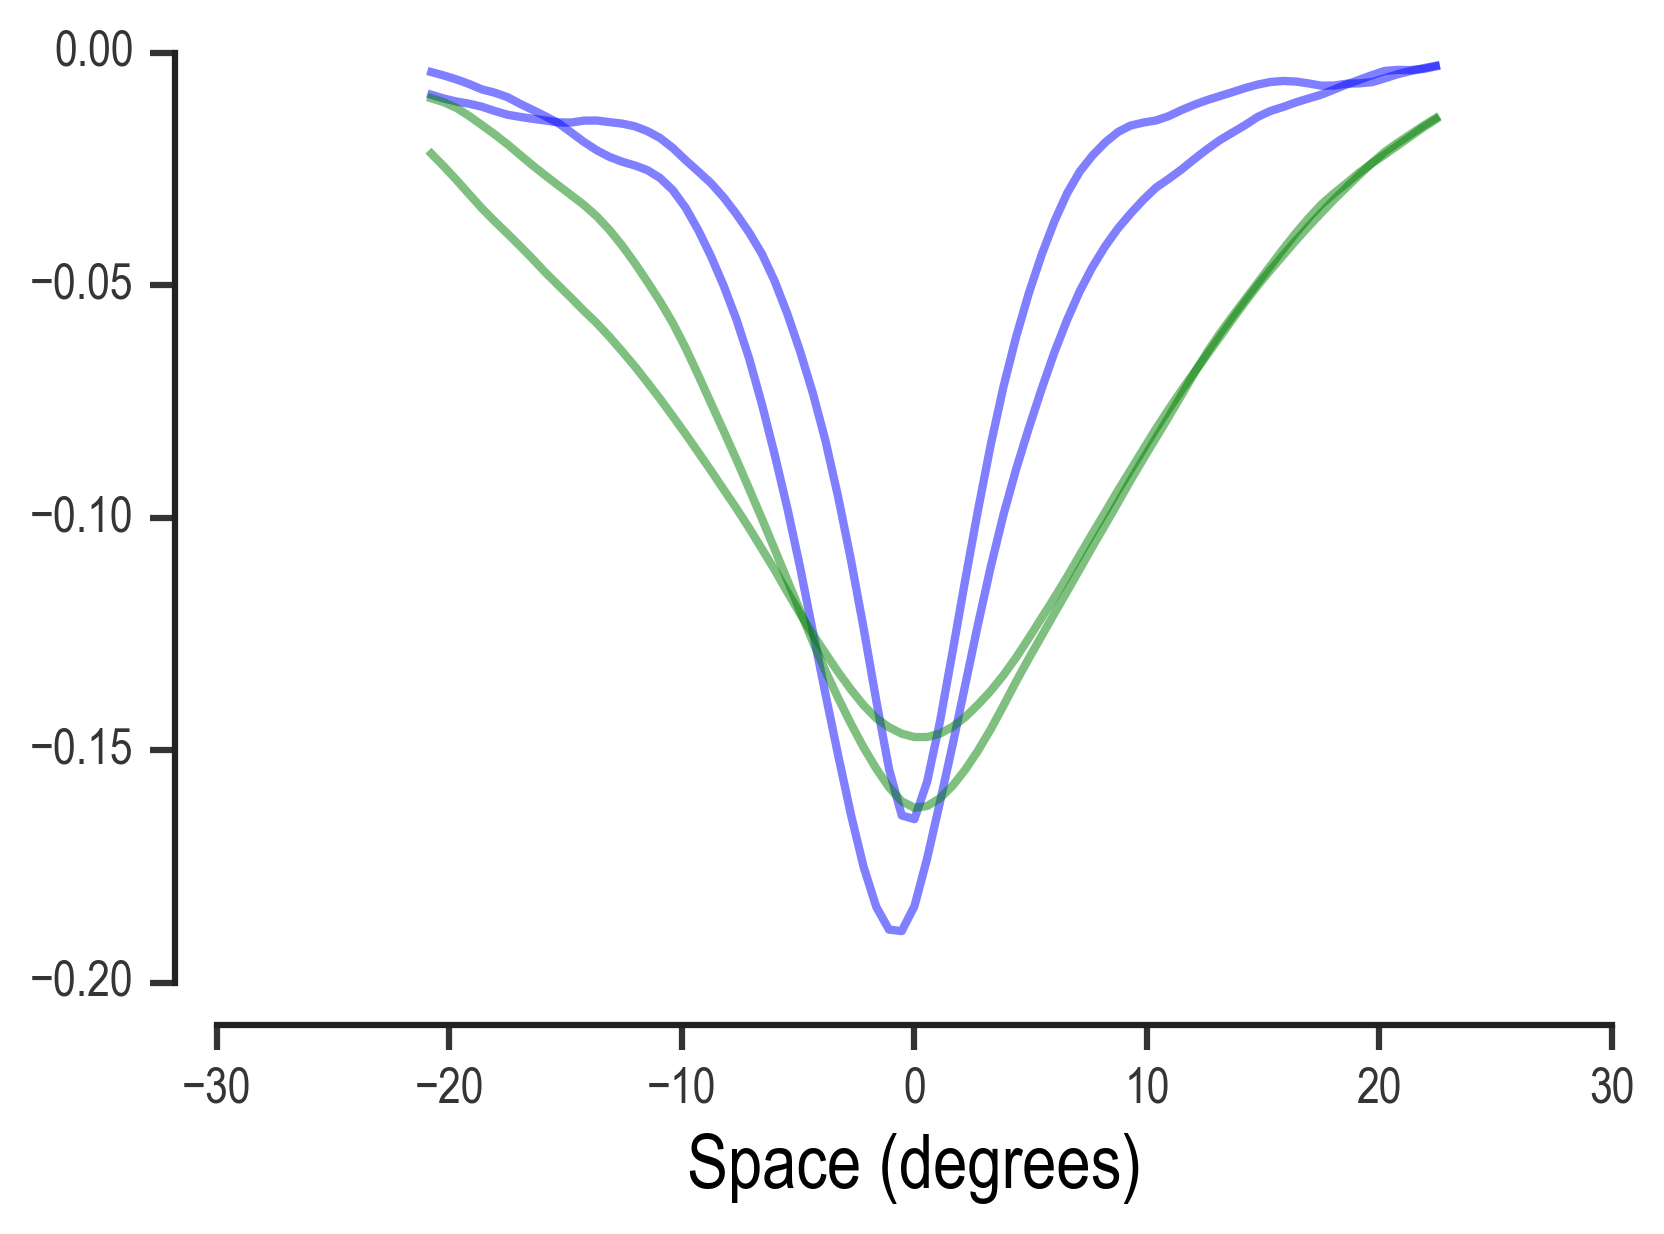

In [8]:
space_constants = {'horizontal': 118./22., 'amacrine': 78./22.}

projective_fields = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['horizontal', 'amacrine']:
        for rf in receptive_fields[celltype]:
            spatial_smoothing = [np.exp(-abs(t)/space_constants[celltype]) for t in np.linspace(np.min(average_spacing),
                                                                                                np.max(average_spacing),
                                                                                                len(average_spacing))]
            proj_field = np.convolve(spatial_smoothing, rf, mode='same')
            proj_field *= np.mean(rf) / np.mean(proj_field)
            projective_fields[celltype].append(proj_field)

colorscheme = 'bg'
for i,celltype in enumerate(sorted(projective_fields.keys())):
    this_color = colorscheme[i]
    for pf in projective_fields[celltype]:
        plt.plot(average_spacing, pf, color=this_color, alpha=0.5, linewidth=2)
plt.xlabel('Space (degrees)', fontsize=18)
adjust_spines(plt.gca())

### Signal

Get the frequency range for average_spacing

In [79]:
freqs = np.linspace(0, 0.5/np.mean(np.diff(average_spacing)), len(np.fft.rfft(average_spacing)))
# if we're going to convolve the signal with a filter, we have to take into account the new convolution length
freqs_padded = np.linspace(0, 0.5/np.mean(np.diff(average_spacing)), 
                           len(np.fft.rfft(average_spacing, n=len(average_spacing)*2 - 1)))

In [10]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd01A'
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 70 files in directory.


In [12]:
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Interpolate signal at same resolution and scale as cell measurements

In [82]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal_padded = func(freqs_padded, *popt_signal)
signal[0] = signal_amps[0]
signal_padded[0] = signal_amps[0]

[ 0.0056951   1.01550079]


/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


### Difference of Gaussians

In [63]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0.)

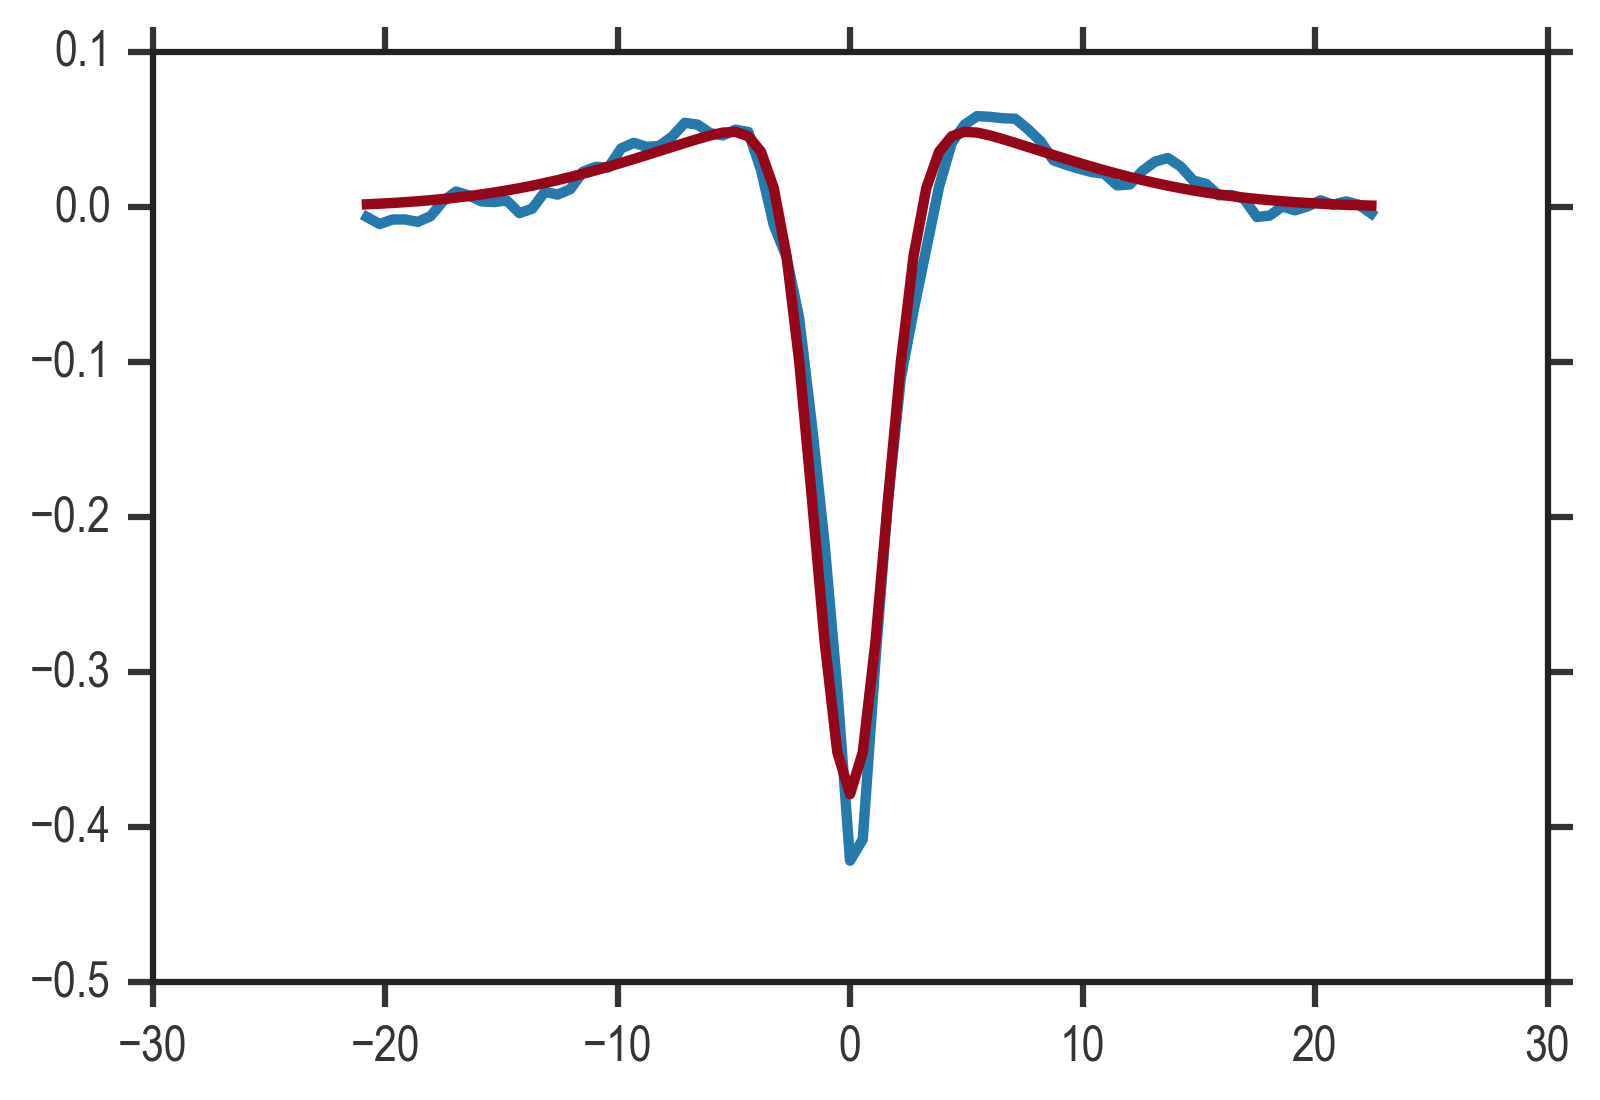

In [70]:
average_ganglion = np.mean(np.stack(receptive_fields['ganglion']), axis=0)
popt, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, average_ganglion)
plt.plot(average_spacing, average_ganglion)
plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt))

In [72]:
popt

array([ -1.53279508,   7.90997606,  -6.50747292,  24.45198112])

In [71]:
mean_center_width = abs(np.min(popt[:2]))

### Noise

In [16]:
input_noise = 0.12
output_noise = 0.35

### Compare ideal filter to different resolution signals

In [28]:
freqs_highres = np.linspace(0, freqs[-1], 1000)
signal_highres = func(freqs_highres, *popt_signal)
signal_highres[0] = signal[0]

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


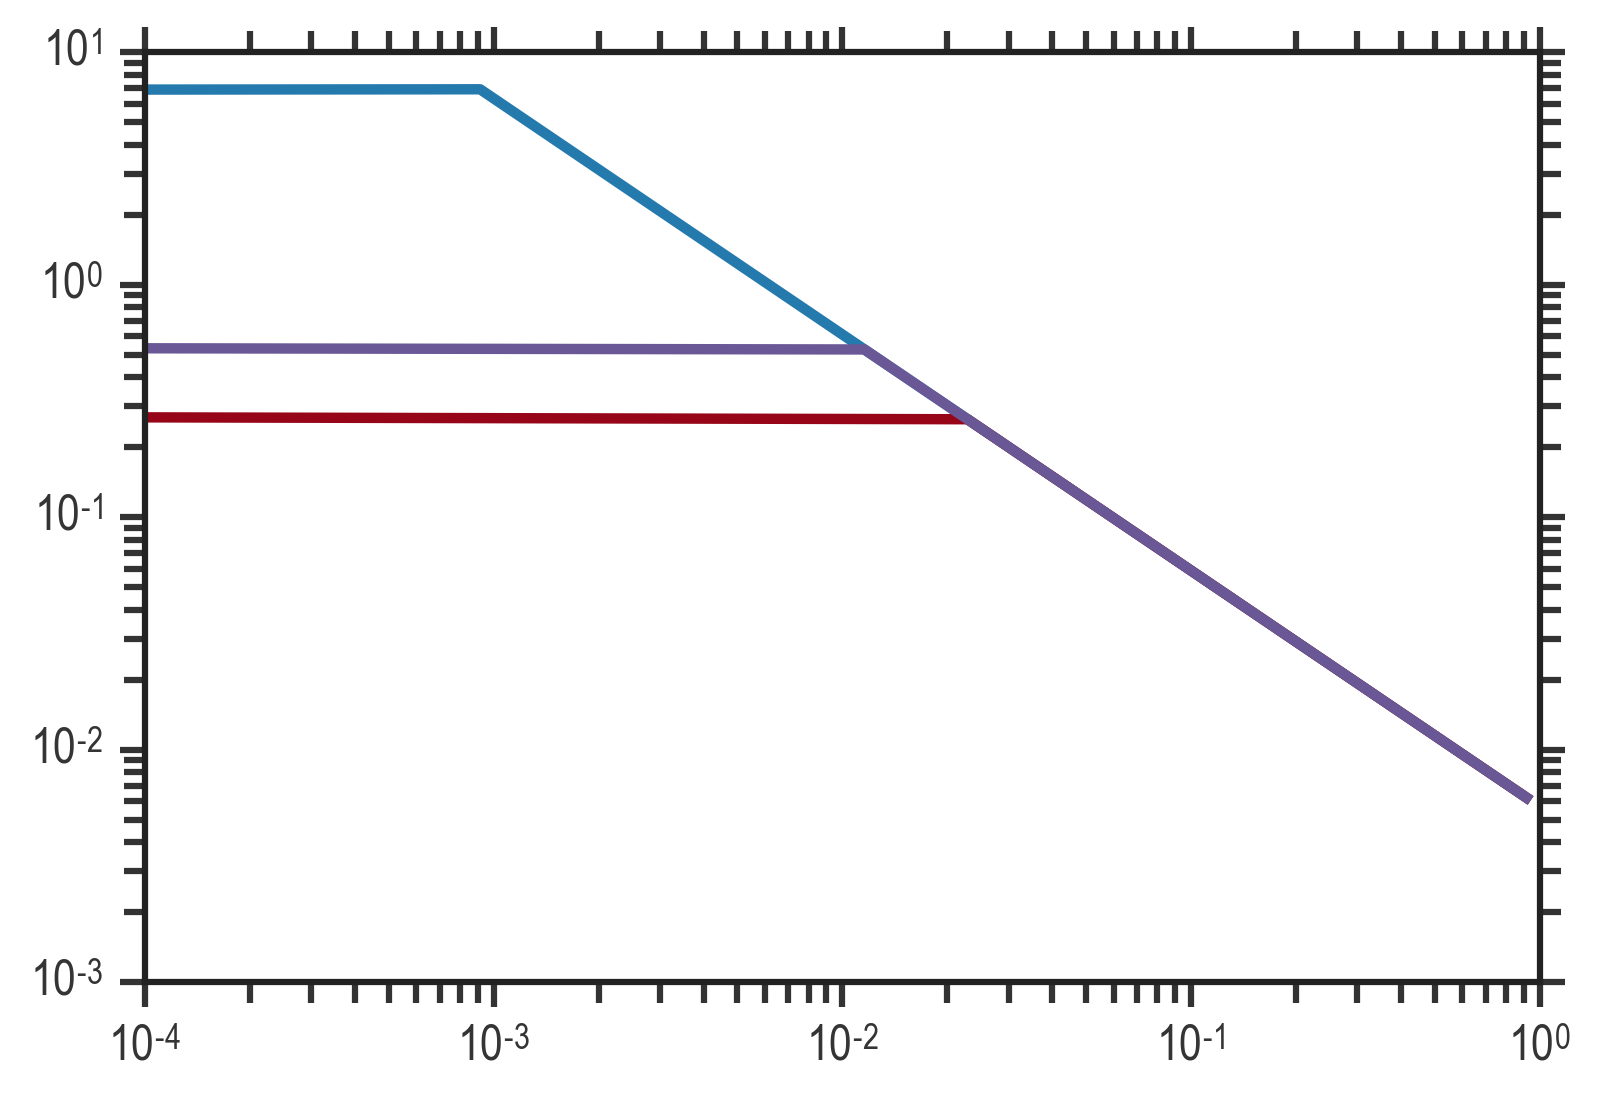

In [83]:
plt.plot(freqs_highres, signal_highres)
plt.plot(freqs, signal)
plt.plot(freqs_padded, signal_padded)
plt.xscale('log')
plt.yscale('log')

In [31]:
ideal_filt = unique_soln(signal**2, input_noise, output_noise)
ideal_filt_highres = unique_soln(signal_highres**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 1.66542878027e-07.
The relative error from this choice of Lagrangian multiplier is 3.69758020854e-07.


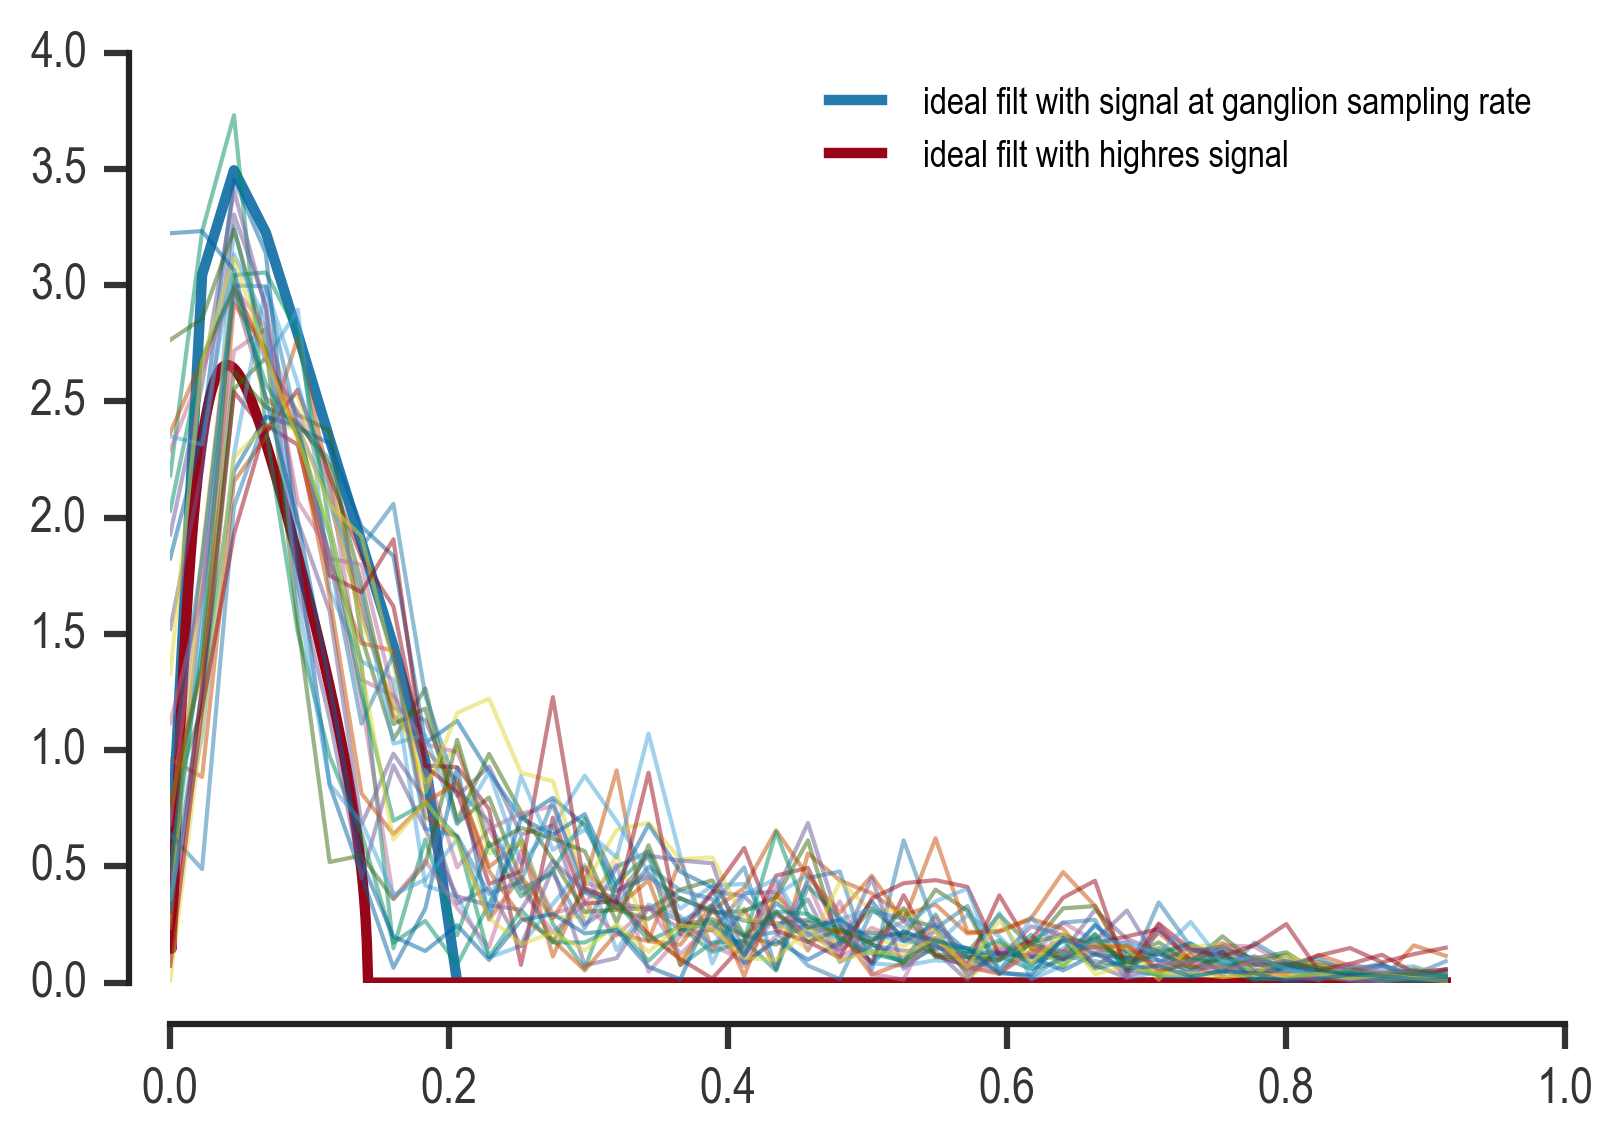

In [44]:
plt.plot(freqs, ideal_filt, label='ideal filt with signal at ganglion sampling rate')
plt.plot(freqs_highres, ideal_filt_highres, label='ideal filt with highres signal')
for g in receptive_fields['ganglion']:
    plt.plot(freqs, abs(np.fft.rfft(g)), linewidth=1, alpha=0.5)
plt.legend(frameon=False, fontsize=9)
adjust_spines(plt.gca())

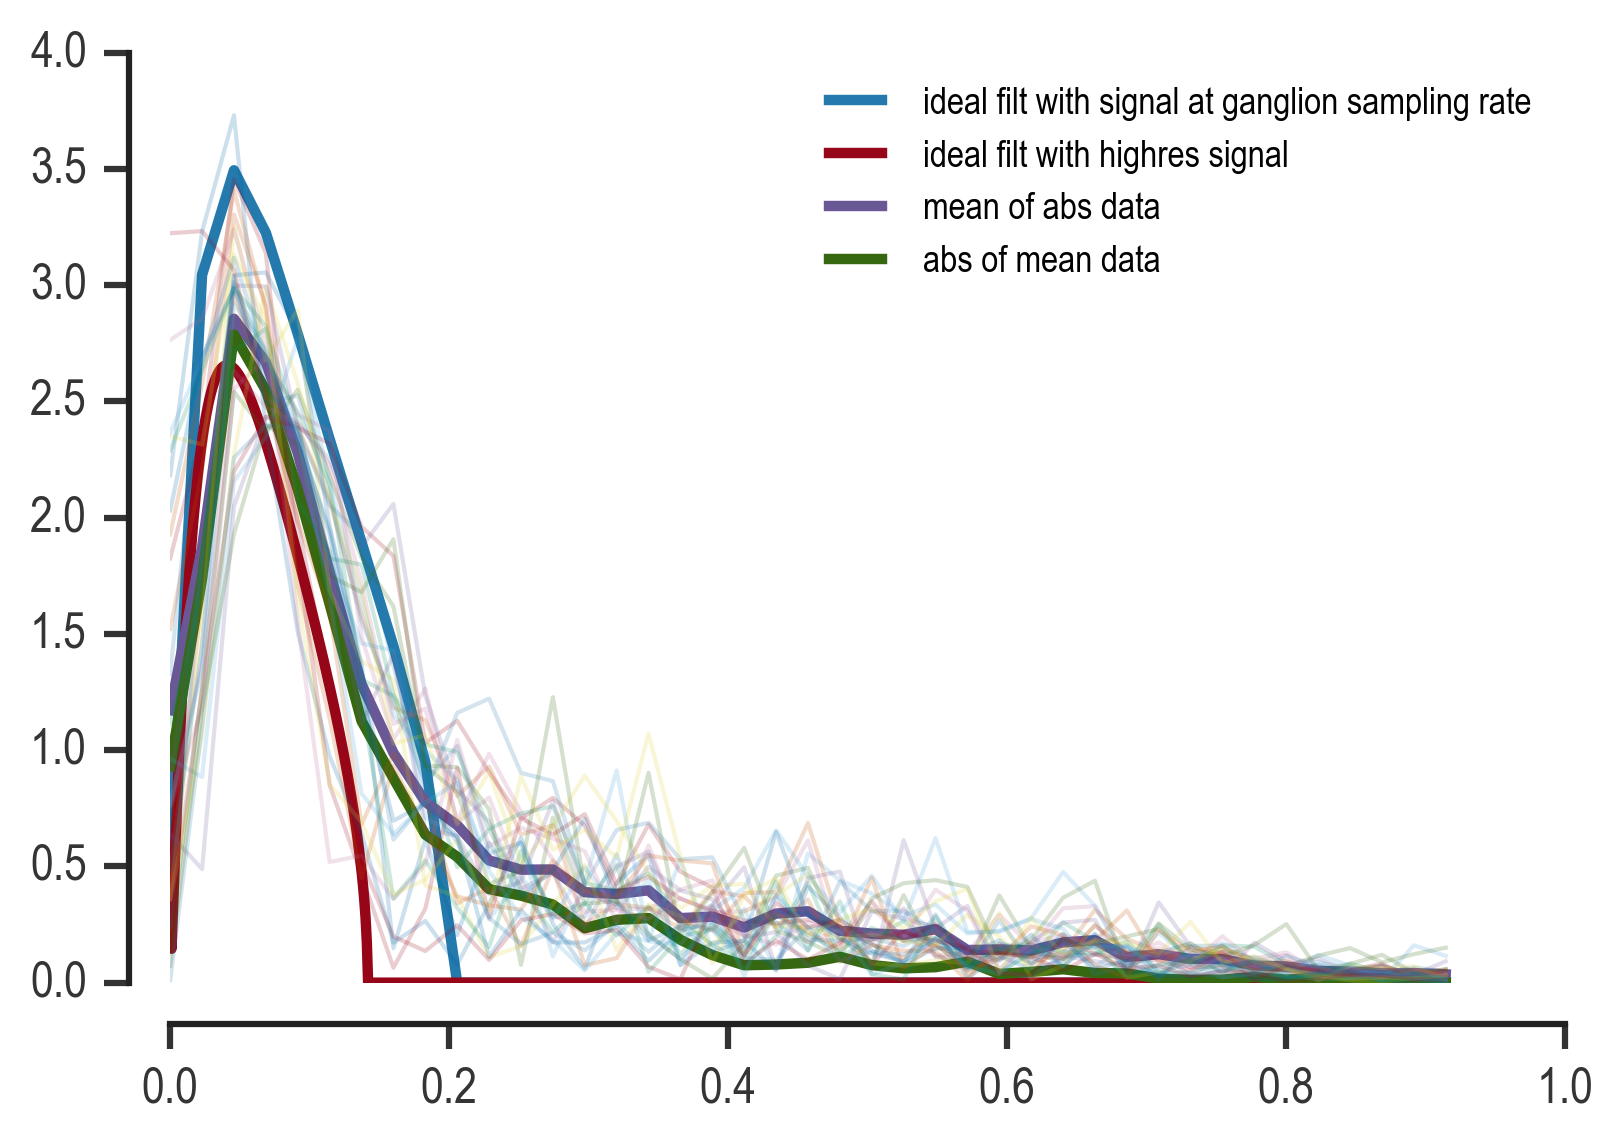

In [49]:
plt.plot(freqs, ideal_filt, label='ideal filt with signal at ganglion sampling rate')
plt.plot(freqs_highres, ideal_filt_highres, label='ideal filt with highres signal')
plt.plot(freqs, np.mean(np.stack([abs(np.fft.rfft(g)) for g in receptive_fields['ganglion']]), axis=0),
        label='mean of abs data')
plt.plot(freqs, abs(np.mean(np.stack([np.fft.rfft(g) for g in receptive_fields['ganglion']]), axis=0)),
        label='abs of mean data')

for g in receptive_fields['ganglion']:
    plt.plot(freqs, abs(np.fft.rfft(g)), linewidth=1, alpha=0.2)
plt.legend(frameon=False, fontsize=9)
adjust_spines(plt.gca())

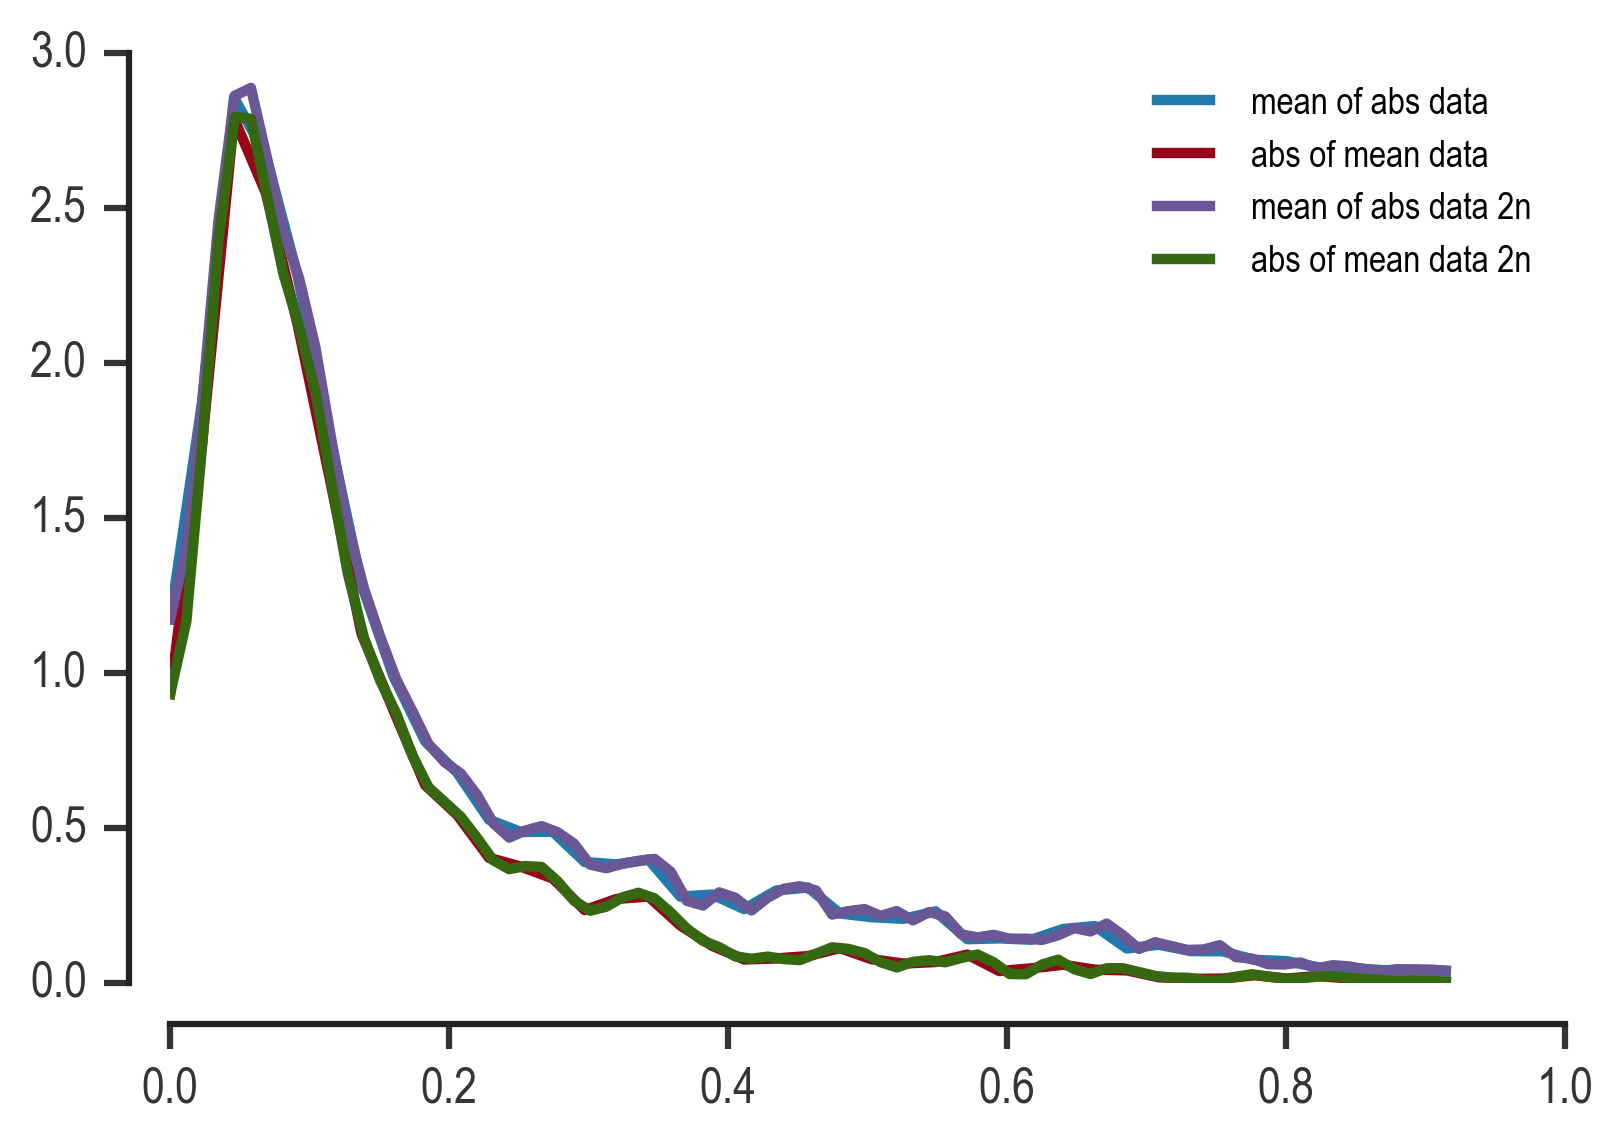

In [121]:
# plt.plot(freqs, ideal_filt, label='ideal filt with signal at ganglion sampling rate')
# plt.plot(freqs_highres, ideal_filt_highres, label='ideal filt with highres signal')
plt.plot(freqs, np.mean(np.stack([abs(np.fft.rfft(g)) for g in receptive_fields['ganglion']]), axis=0),
        label='mean of abs data')
plt.plot(freqs, abs(np.mean(np.stack([np.fft.rfft(g) for g in receptive_fields['ganglion']]), axis=0)),
        label='abs of mean data')
plt.plot(np.linspace(0, freqs[-1], 2*(len(freqs)-1)),
         np.mean(np.stack([abs(np.fft.rfft(g, n=2*len(g)-1)) for g in receptive_fields['ganglion']]), axis=0),
         label='mean of abs data 2n')
plt.plot(np.linspace(0, freqs[-1], 2*(len(freqs)-1)),
         abs(np.mean(np.stack([np.fft.rfft(g, n=2*len(g)-1) for g in receptive_fields['ganglion']]), axis=0)),
         label='abs of mean data 2n')
# plt.plot(freqs, abs(np.fft.rfft(np.mean(receptive_fields['ganglion'], axis=0))), color='c', label='abs fft of mean space')
plt.legend(frameon=False, fontsize=9)
adjust_spines(plt.gca())

In [86]:
ganglion_padded = abs(np.mean(np.stack([np.fft.rfft(g, n=2*len(g)-1) for g in receptive_fields['ganglion']]), axis=0))

In [99]:
target_variance = 10
def constrain_filt_var(filt_const):
    filt_variance = get_output_var(input_noise, output_noise, signal_padded, filt_const*ganglion_padded)
    return (target_variance - filt_variance)**2

ganglion_filt_const_opt = scipy.optimize.minimize(constrain_filt_var, 0.4)
ganglion_filt_const = abs(ganglion_filt_const_opt['x'])

In [100]:
ganglion_filt_const_opt

      fun: 3.1512230495728068e-18
 hess_inv: array([[ 106741.33621221]])
      jac: array([ -1.85601572e-10])
  message: 'Optimization terminated successfully.'
     nfev: 48
      nit: 2
     njev: 16
   status: 0
  success: True
        x: array([ 258.17692703])

In [102]:
ganglion_padded_constrained = ganglion_filt_const * ganglion_padded

## Redo information calculation

Couldn't fit cell 15
Couldn't fit cell 21
Couldn't fit cell 27


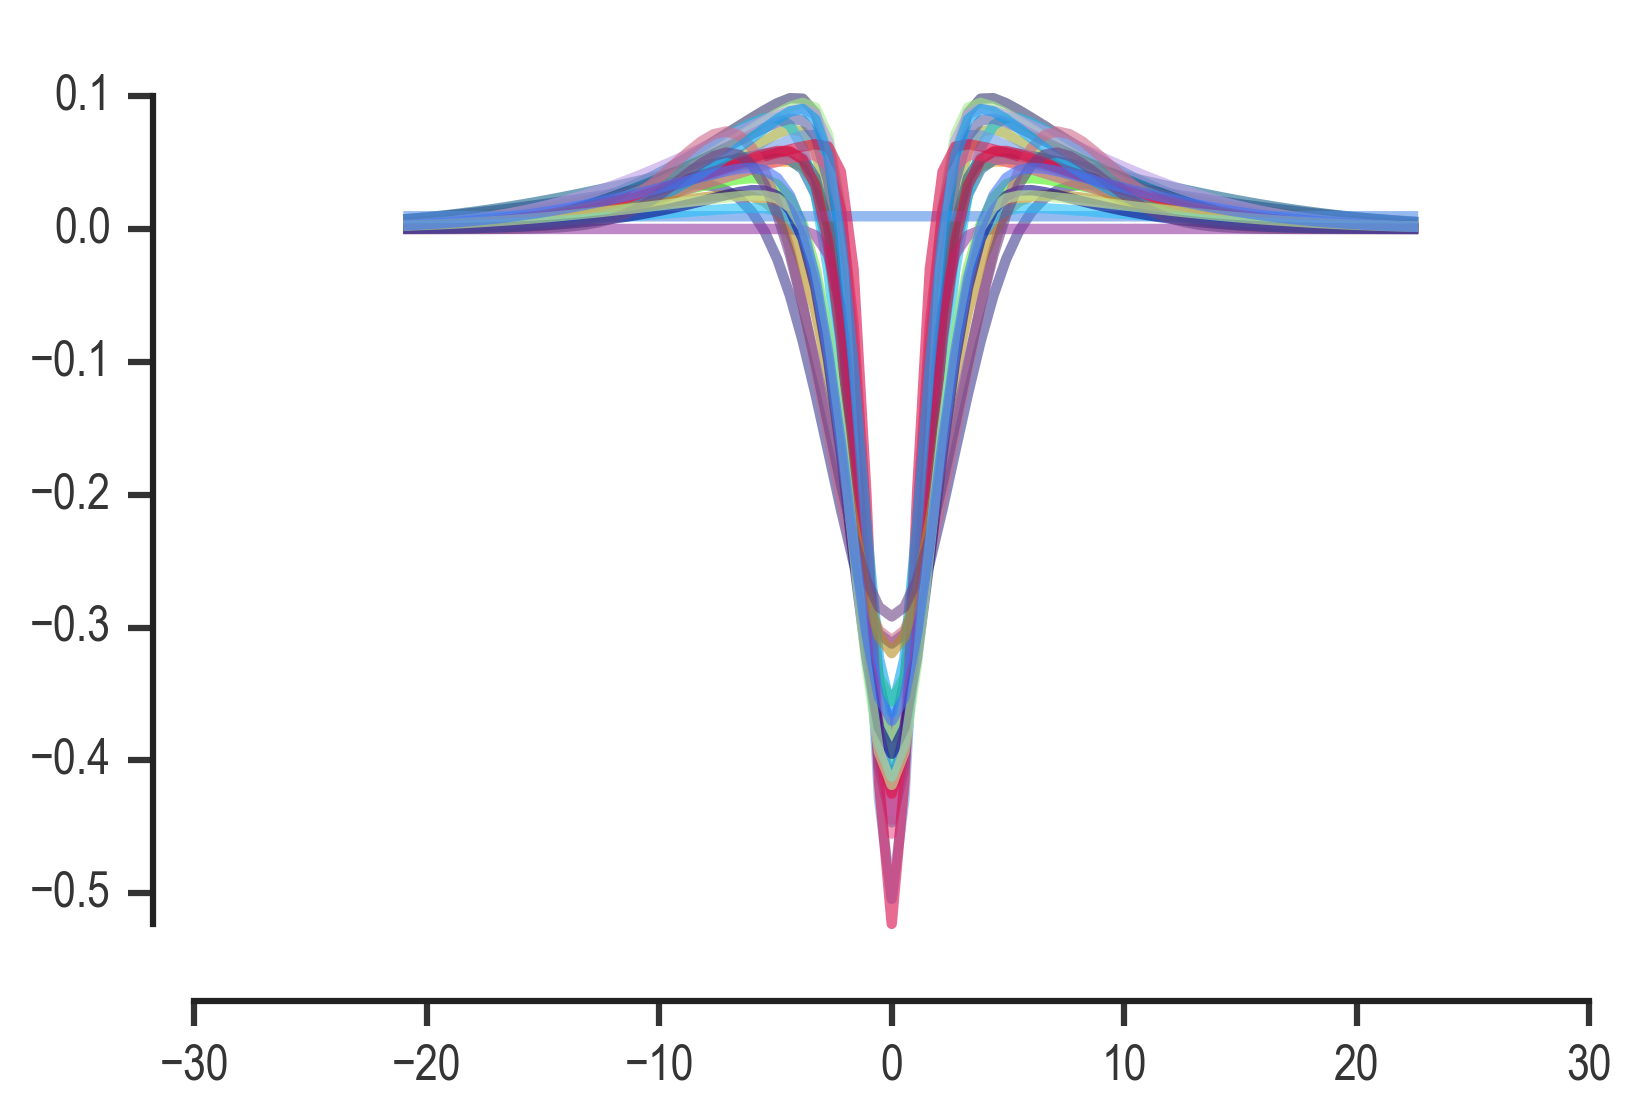

In [67]:
center_widths = []
surround_widths = []
for idg, g in enumerate(receptive_fields['ganglion']):
    try:
        popt_this, pcov = curve_fit(diff_of_gauss_mu0, average_spacing, g)
        center_widths.append(np.min(abs(popt_this[:2])))
        surround_widths.append(np.max(abs(popt_this[:2])))
        plt.plot(average_spacing, diff_of_gauss_mu0(average_spacing, *popt_this), color=np.random.rand(3), alpha=0.6)
    except:
        print("Couldn't fit cell %d" %idg)
        
plt.ylim(-.55, .15)
adjust_spines(plt.gca())

In [74]:
center_width = np.median(center_widths)
print(center_width)

1.4211101852


In [75]:
# Get original data
horz_pfs = get_horizontal_projective_field()
ama_pfs  = get_amacrine_projective_field()

# get means of the projective fields
space_h, horz_pf, horz_sem = get_mean(horz_pfs)
space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

# interpolate horz and ama to get a unified space; mode='valid'
horz_interp = interp1d(space_h, horz_pf, kind='linear', bounds_error=False, fill_value='extrapolate')
ama_interp  = interp1d(space_a, ama_pf, kind='linear', bounds_error=False, fill_value='extrapolate')

# project interpolations on unified space
horz_pf     = horz_interp(average_spacing)
ama_pf      = ama_interp(average_spacing)

# make center
center = gaussian(x=average_spacing, sigma=center_width, mu=0.) # gaussian

In [77]:
def rf_cached(horz_weight, center_weight):
    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])
    return center_weight*center + (1 - center_weight)*(horz_weight*horz_pf + (1 - horz_weight)*ama_pf)

In [105]:
input_noises = [0.01, 0.12, 0.4]
info_colormaps_vs_noise_innersum = collections.defaultdict(list)
info_colormaps_vs_noise_outersum = collections.defaultdict(list)
mse_colormaps_vs_noise_ganglion = collections.defaultdict(list)
mse_colormaps_vs_noise_ideal = collections.defaultdict(list)
mse_colormaps_vs_noise_ideal_hr = collections.defaultdict(list)

resolution = 150
target_variance = 10
horz_weights = np.linspace(0.,1.,resolution)
center_weights = np.linspace(0.,1.,resolution)
init_filt_const = 0.4

for input_noise in input_noises:
    info_color_map_innersum = np.zeros((resolution, resolution))
    info_color_map_outersum = np.zeros((resolution, resolution))
    mse_color_map_ganglion = np.zeros((resolution, resolution))
    mse_color_map_ideal = np.zeros((resolution, resolution))
    mse_color_map_ideal_hr = np.zeros((resolution, resolution))
    
    ideal_filt = unique_soln(signal**2, input_noise, output_noise)
    ideal_filt_highres = unique_soln(signal_highres**2, input_noise, output_noise)
    
    def constrain_filt_var(filt_const):
        filt_variance = get_output_var(input_noise, output_noise, signal, filt_const*ideal_filt)
        return (target_variance - filt_variance)**2  
    ideal_filt_const_opt = scipy.optimize.minimize(constrain_filt_var, 0.4)
    ideal_filt_const = abs(ideal_filt_const_opt['x'])
    
    def constrain_filt_var(filt_const):
        filt_variance = get_output_var(input_noise, output_noise, signal_highres, filt_const*ideal_filt_highres)
        return (target_variance - filt_variance)**2
    ideal_filt_hr_const_opt = scipy.optimize.minimize(constrain_filt_var, 0.4)
    ideal_filt_hr_const = abs(ideal_filt_hr_const_opt['x'])
    
    ideal_filt_interp = interp1d(freqs, ideal_filt_const*ideal_filt, kind='slinear', 
                                 bounds_error=False, fill_value=[0])
    ideal_filt_hr_interp = interp1d(freqs_highres, ideal_filt_hr_const*ideal_filt_highres, kind='slinear',
                                   bounds_error=False, fill_value=[0])
    ideal = ideal_filt_interp(freqs_padded)
    ideal_hr = ideal_filt_hr_interp(freqs_padded)

    for idh,hw in tqdm(enumerate(horz_weights)):
        for idc,cw in enumerate(center_weights):
            rf_model = rf_cached(hw, cw)
            rf_filt = abs(np.fft.rfft(rf_model, n=2*len(rf_model)-1))

            def constrain_filt_var(filt_const):
                filt_variance = get_output_var(input_noise, output_noise, signal_padded, filt_const*rf_filt)
                return (target_variance - filt_variance)**2

            filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
            filt_const = abs(filt_const_opt['x'])

            # compute total information for this particular model
            snr = get_snr(input_noise, output_noise, signal_padded, filt_const*rf_filt)
            signal_vars = get_signal_var(signal_padded, filt_const*rf_filt, total_var=False)
            noise_vars = get_noise_var(input_noise, output_noise, filt_const*rf_filt, total_var=False)
            info_color_map_innersum[idh,idc] = 0.5*np.log2(1 + snr)
            info_color_map_outersum[idh,idc] = 0.5*np.sum(np.log2(1 + signal_vars/noise_vars))
            
            # compute the MSE difference between this model filter and the ideal filter
            mse_color_map_ganglion[idh,idc] = np.mean((ganglion_padded_constrained - filt_const*rf_filt)**2)
            mse_color_map_ideal[idh,idc] = np.mean((ideal - filt_const*rf_filt)**2)
            mse_color_map_ideal_hr[idh,idc] = np.mean((ideal_hr - filt_const*rf_filt)**2)

#         if idh % 10 == 0:
#             print('On iteration %d/%d' %(idh*resolution, resolution*resolution))
            
    info_colormaps_vs_noise_innersum[input_noise] = info_color_map_innersum
    info_colormaps_vs_noise_outersum[input_noise] = info_color_map_outersum
    mse_colormaps_vs_noise_ganglion[input_noise] = mse_color_map_ganglion
    mse_colormaps_vs_noise_ideal[input_noise] = mse_color_map_ideal
    mse_colormaps_vs_noise_ideal_hr[input_noise] = mse_color_map_ideal_hr


The relative error from this choice of Lagrangian multiplier is 3.34672264259e-07.
The relative error from this choice of Lagrangian multiplier is 1.10855208407e-06.
The relative error from this choice of Lagrangian multiplier is 1.49156212842e-07.


The relative error from this choice of Lagrangian multiplier is 1.38251724728e-07.
The relative error from this choice of Lagrangian multiplier is 1.52168127011e-08.


The relative error from this choice of Lagrangian multiplier is 2.0561831499e-08.


In [108]:
info_colormaps_vs_noise_innersum.keys()

dict_keys([0.12, 0.4, 0.01])

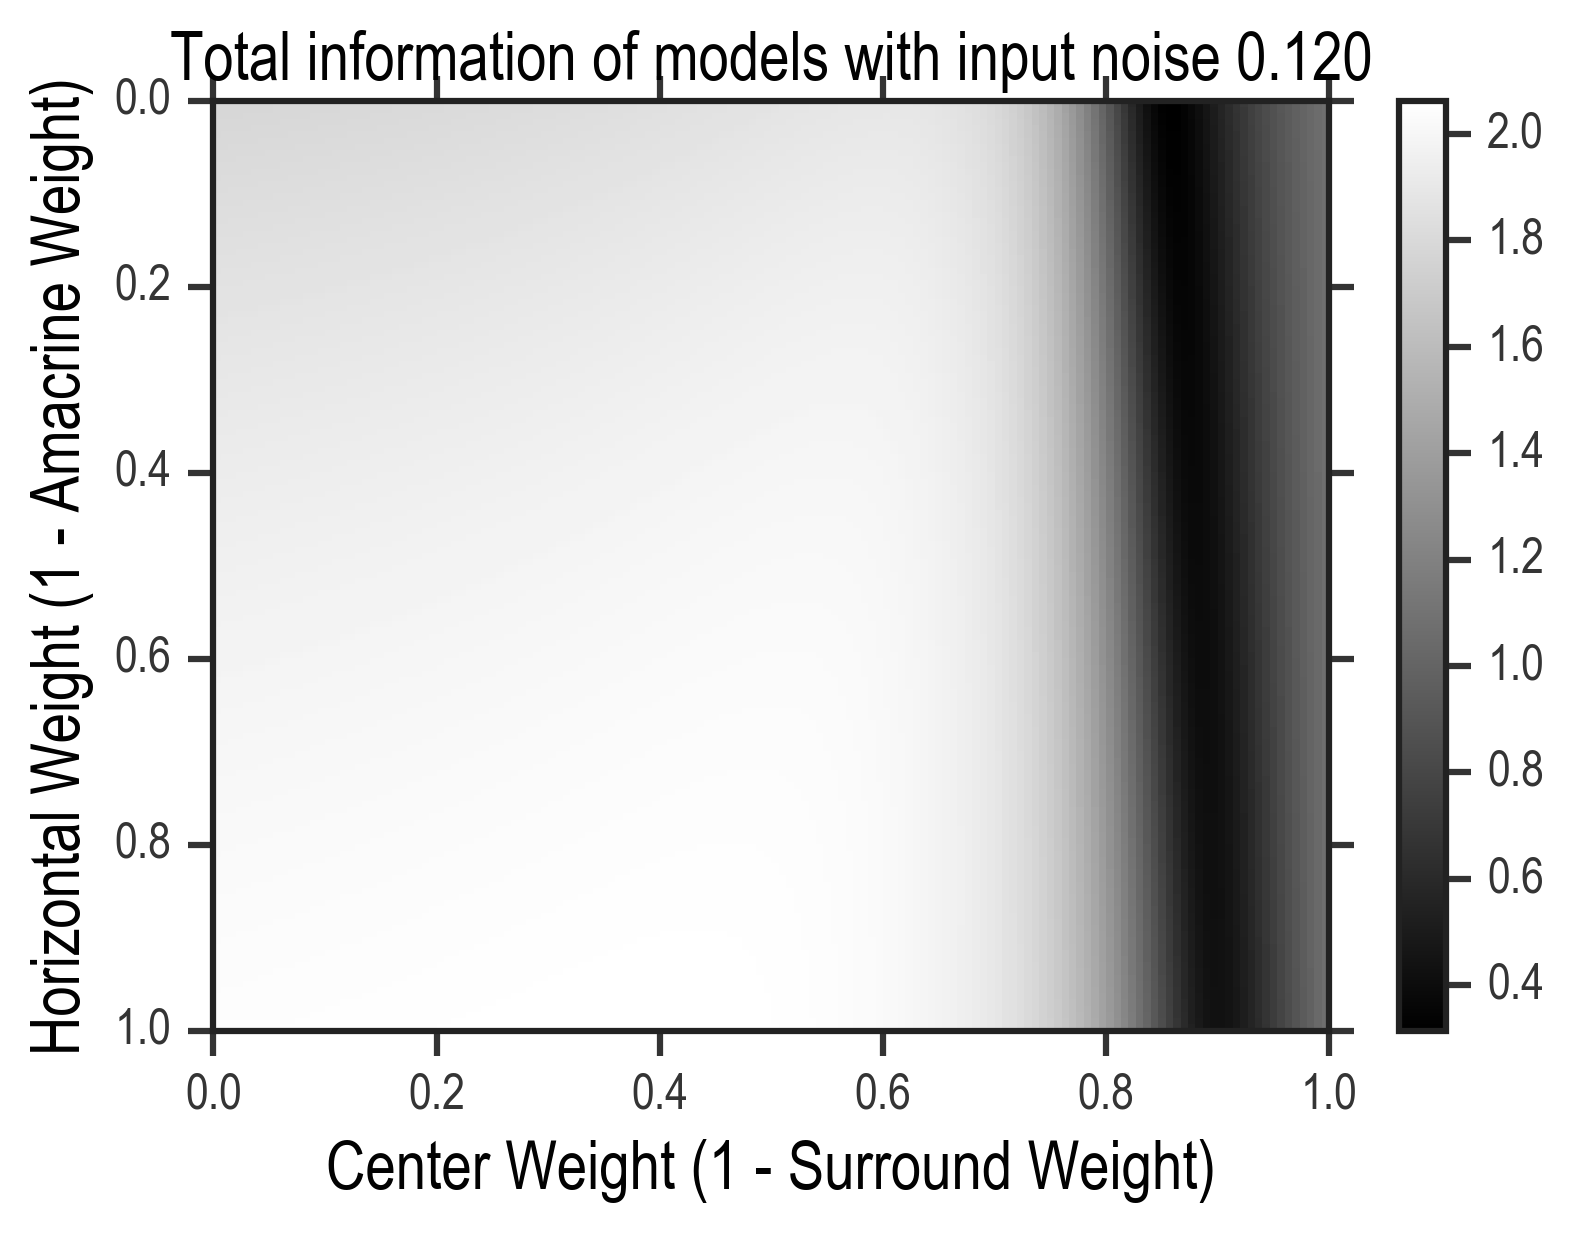

In [124]:
plt.imshow(info_colormaps_vs_noise_innersum[0.12], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.title('Total information of models with input noise %0.3f' %input_noises[1], fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)
plt.colorbar()

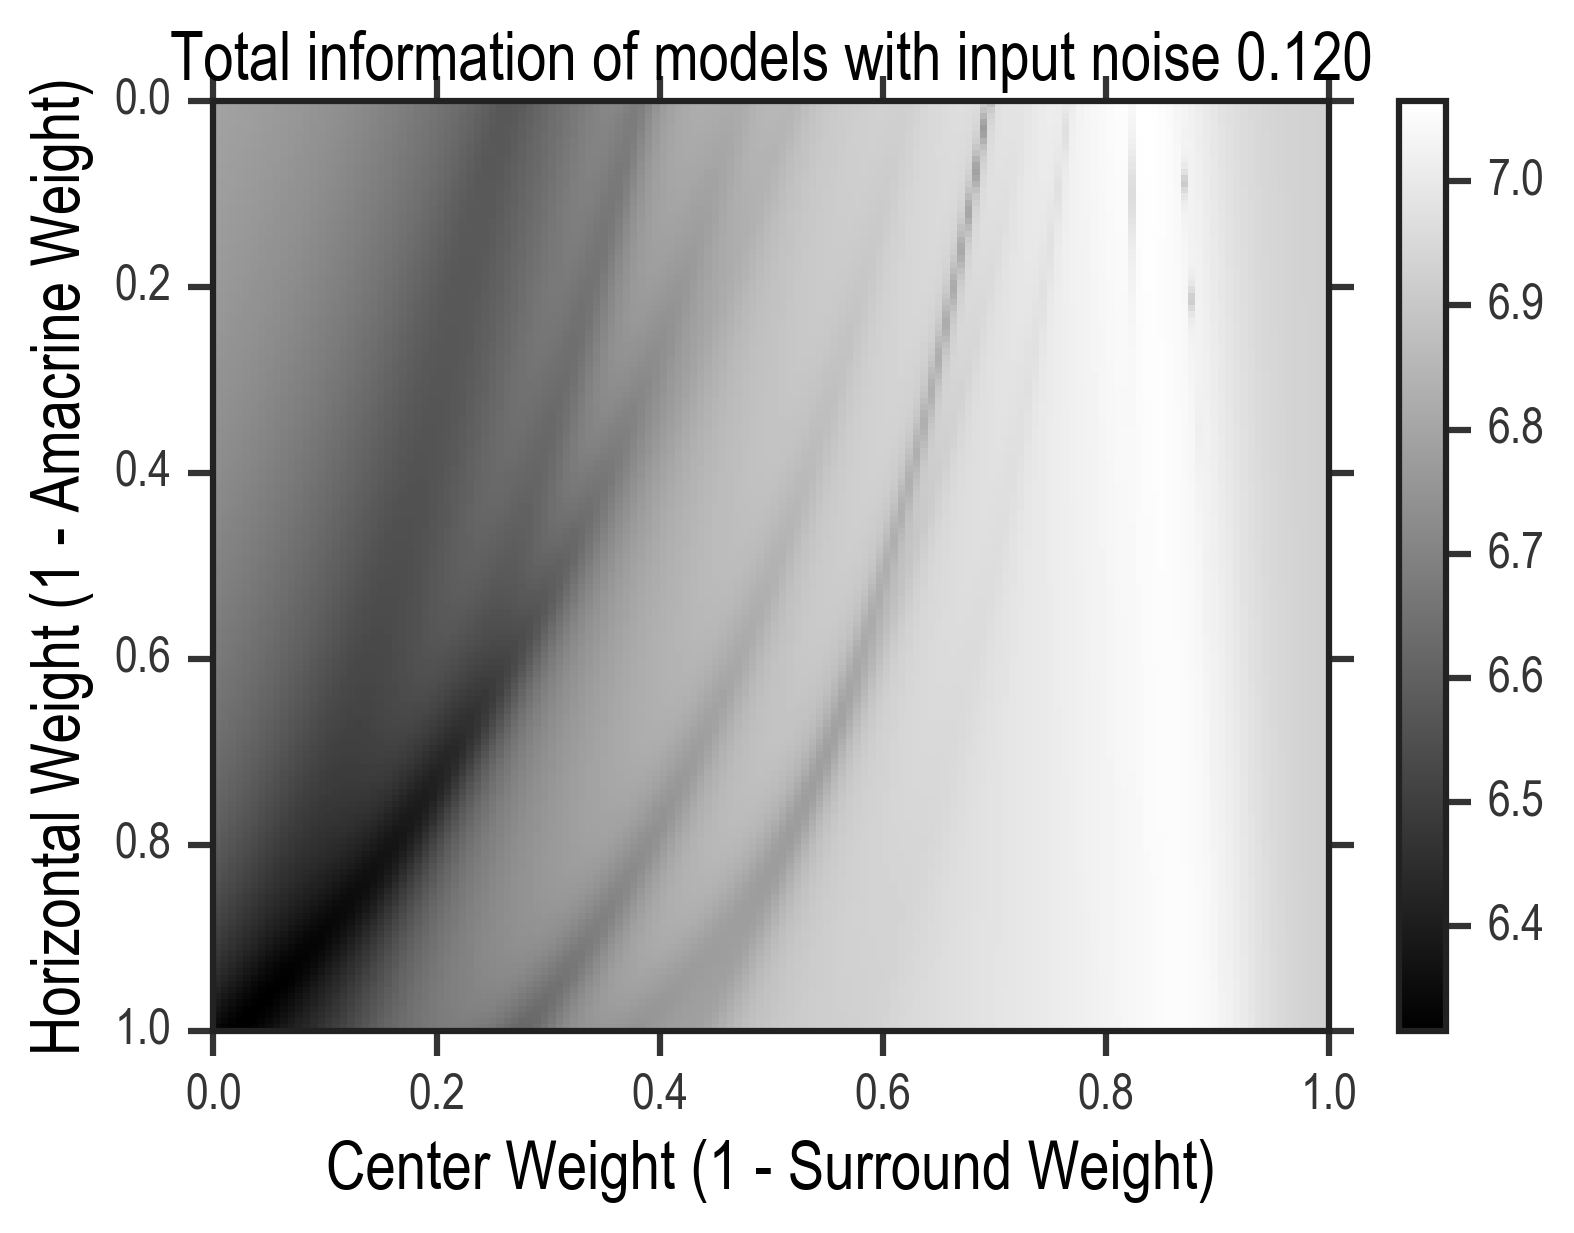

In [127]:
plt.imshow(info_colormaps_vs_noise_outersum[0.12], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.title('Total information of models with input noise %0.3f' %input_noises[1], fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)
# plt.xlim(0.8,1)

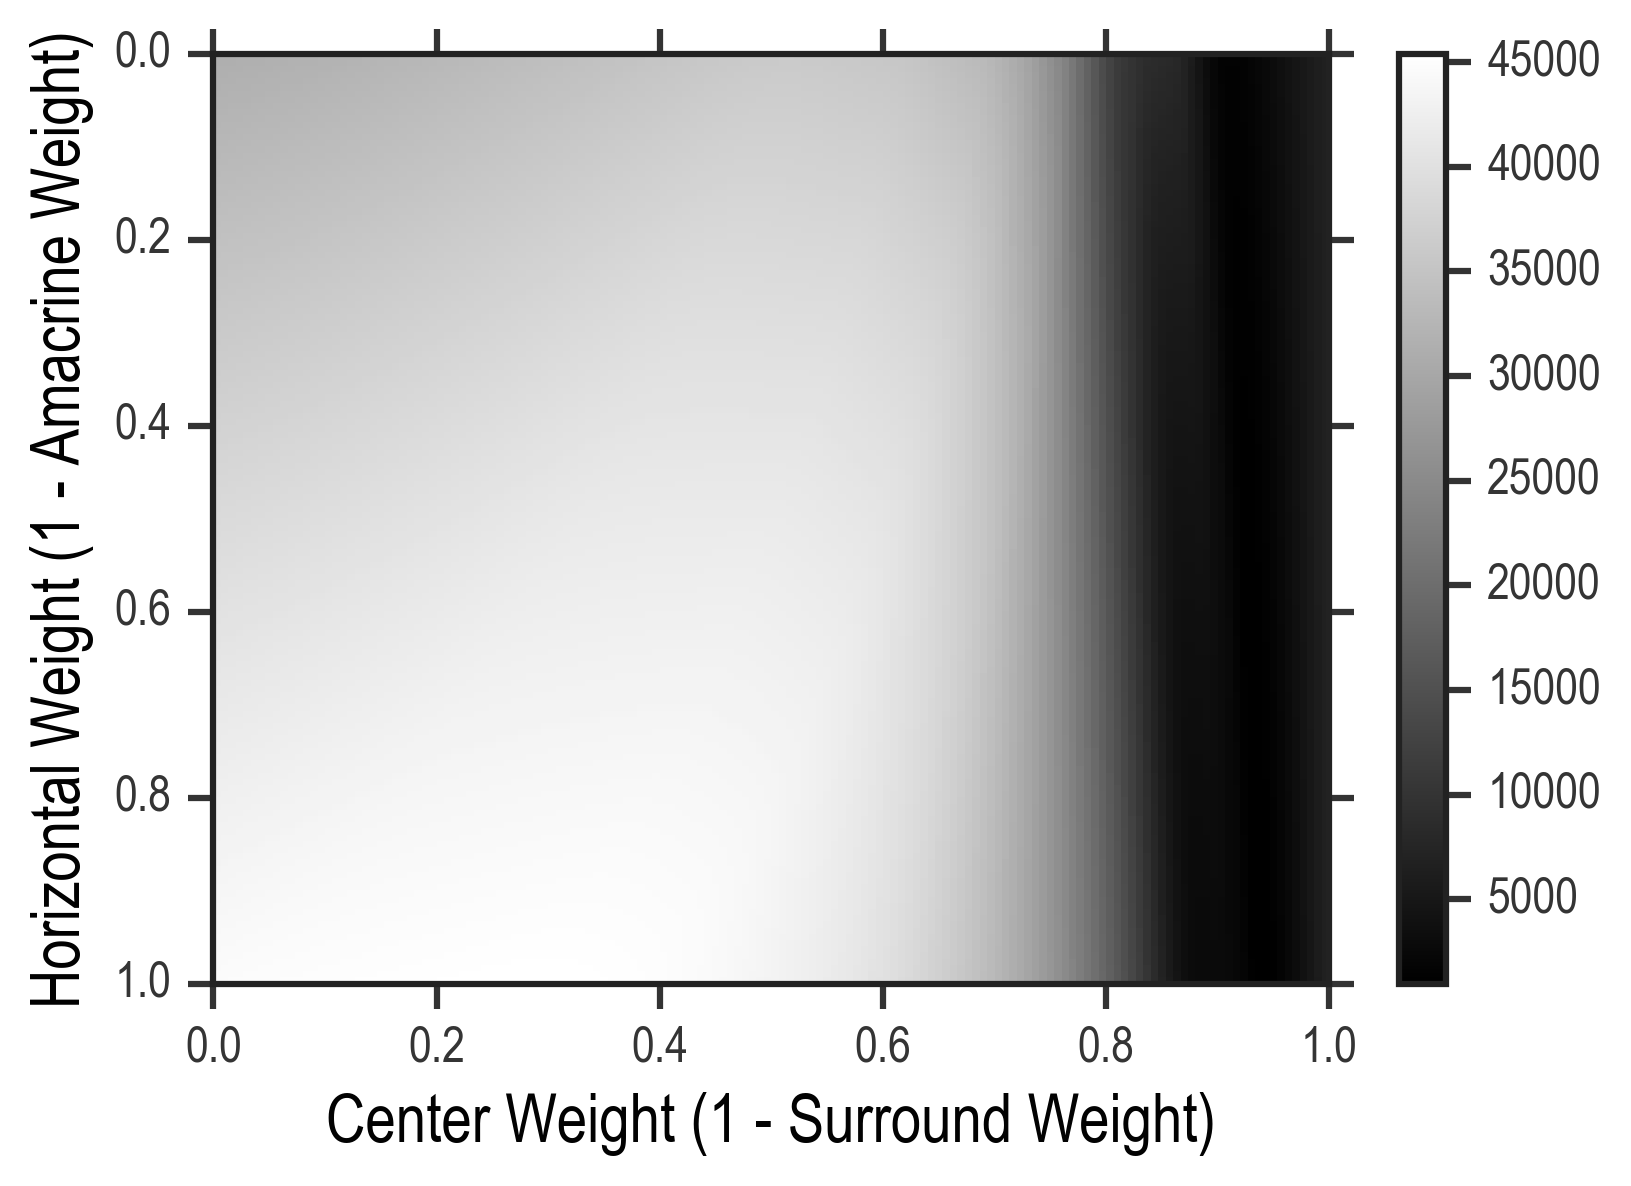

In [134]:
plt.imshow(mse_colormaps_vs_noise_ganglion[0.12], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

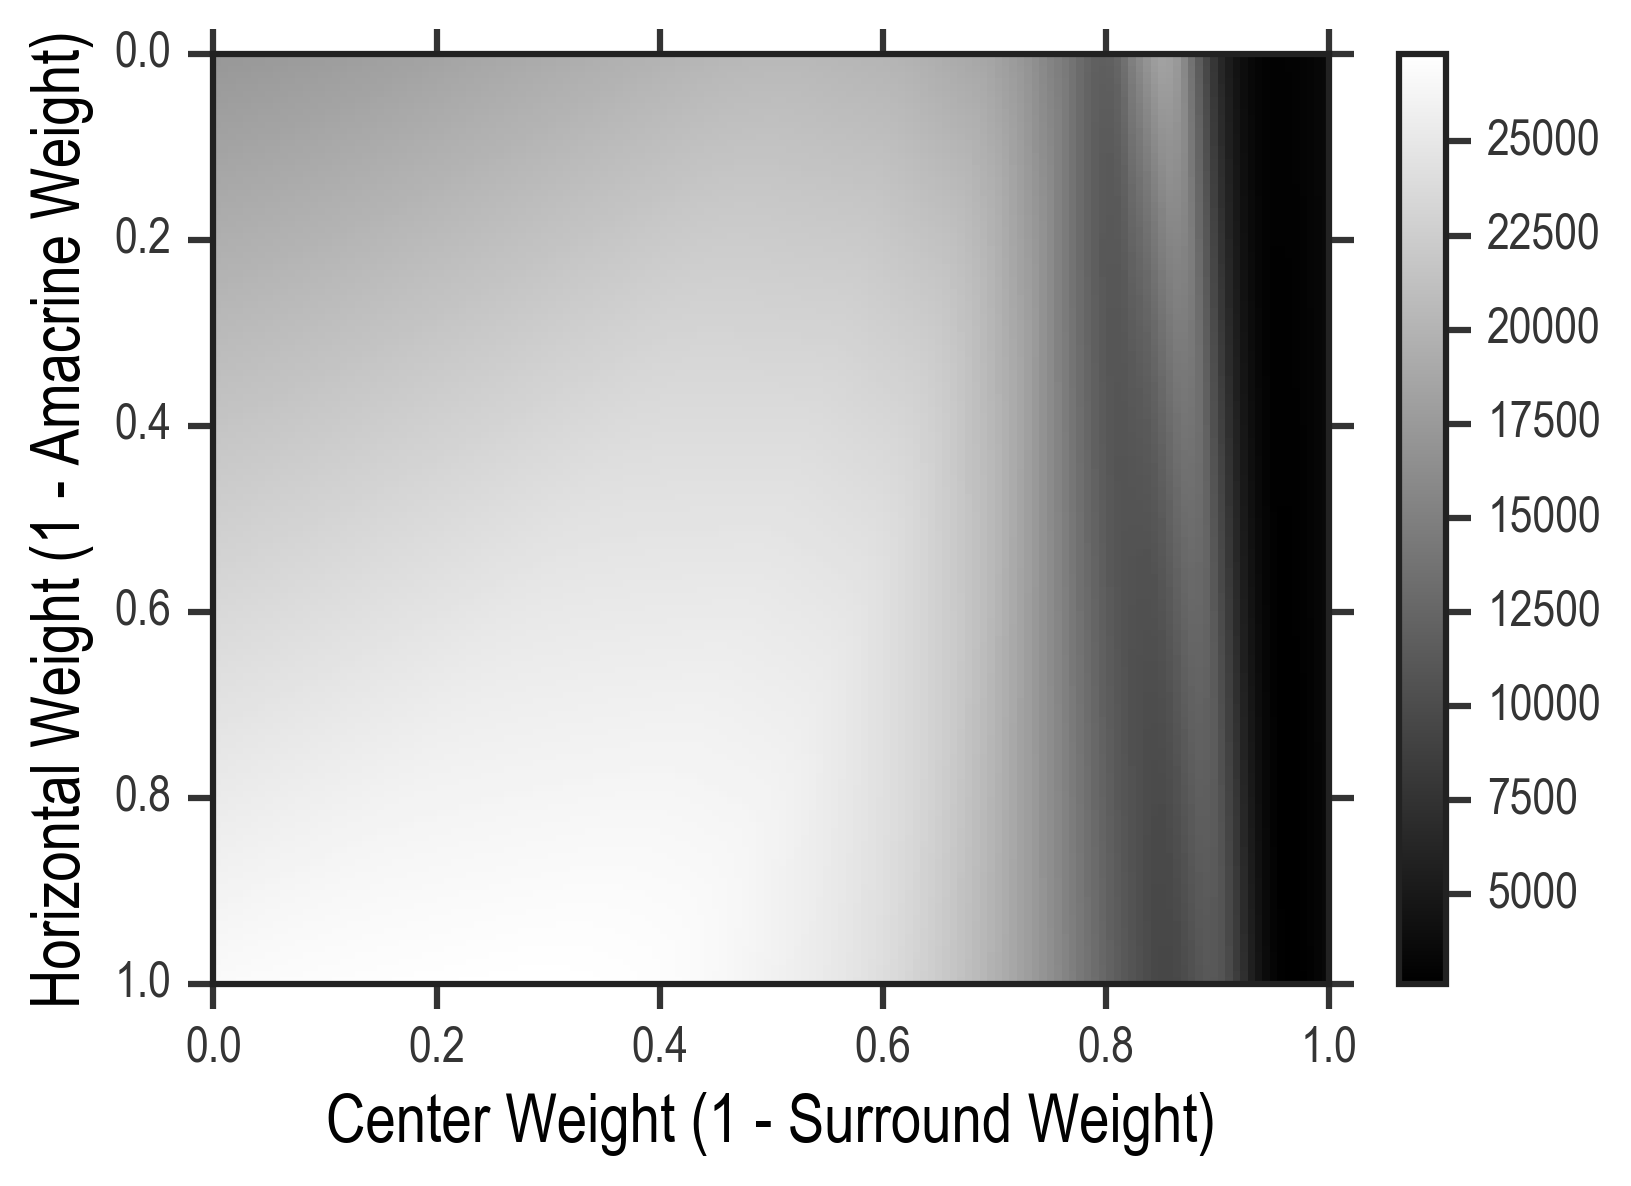

In [135]:
plt.imshow(mse_colormaps_vs_noise_ideal[0.12], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

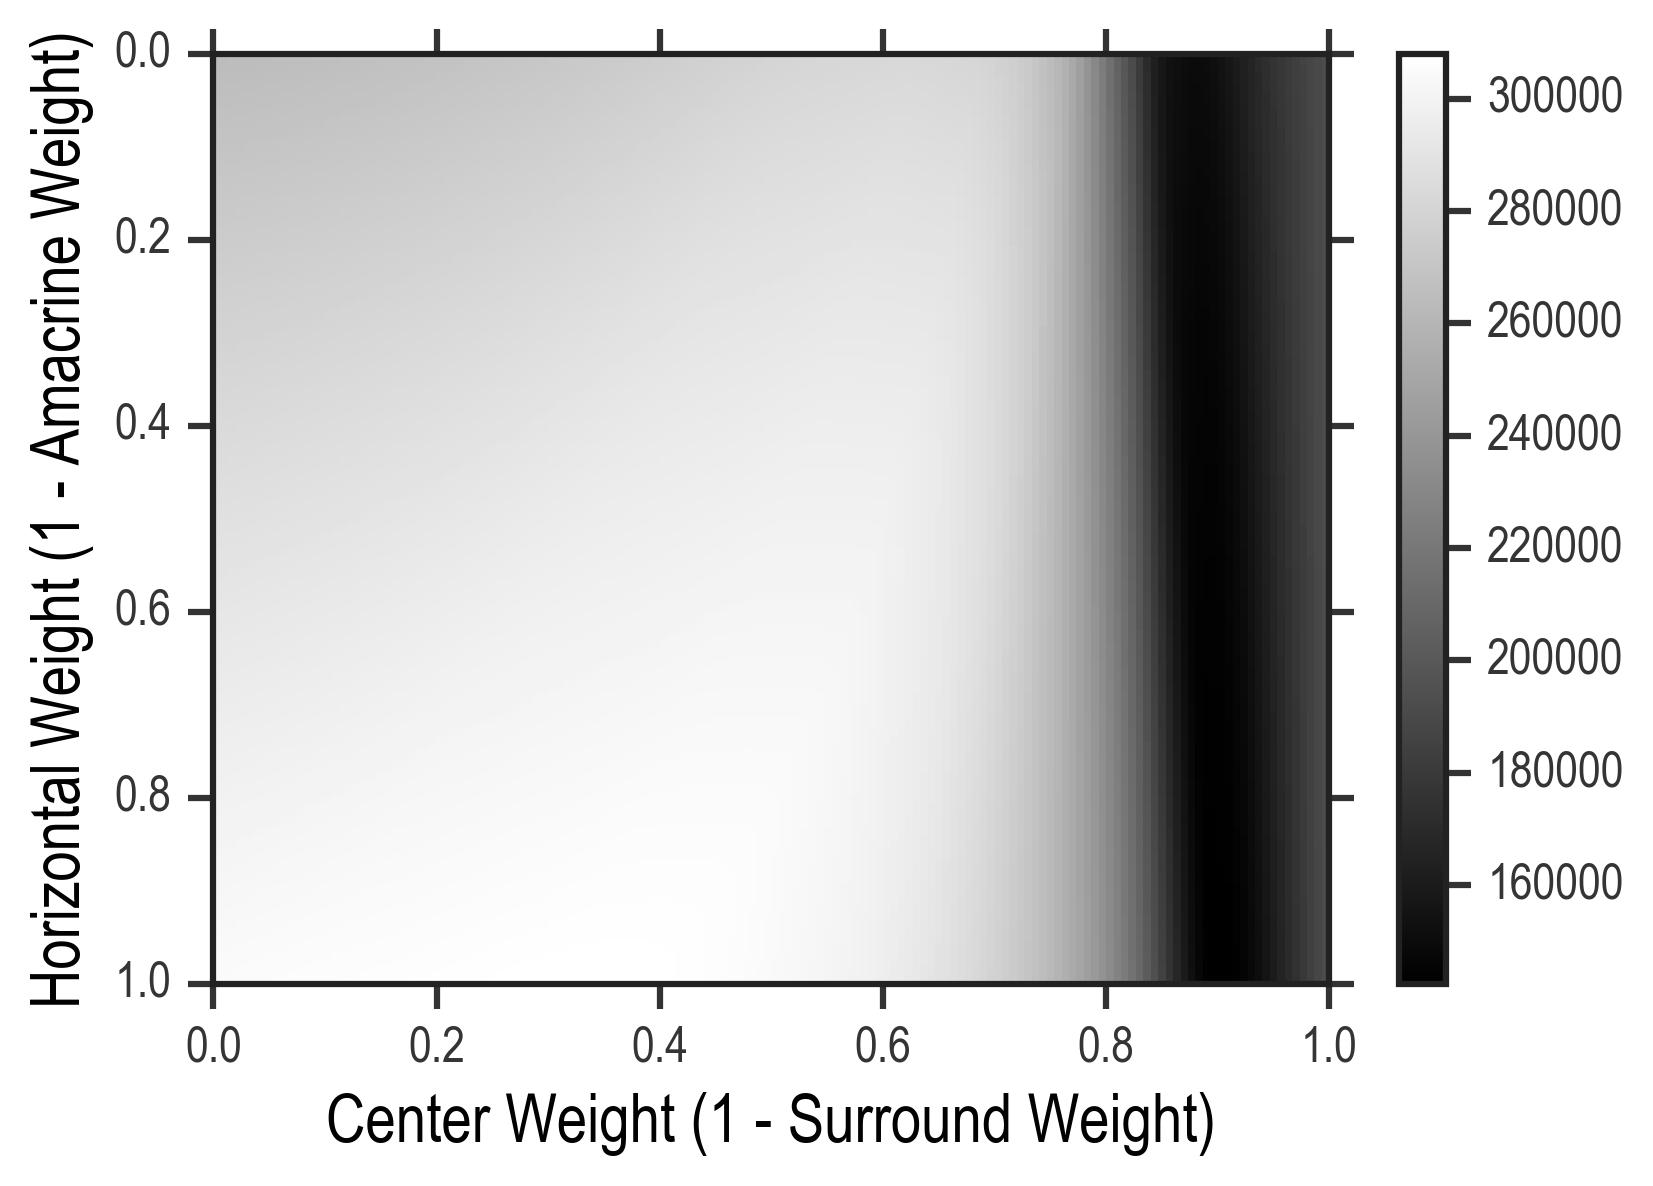

In [136]:
plt.imshow(mse_colormaps_vs_noise_ideal_hr[0.12], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

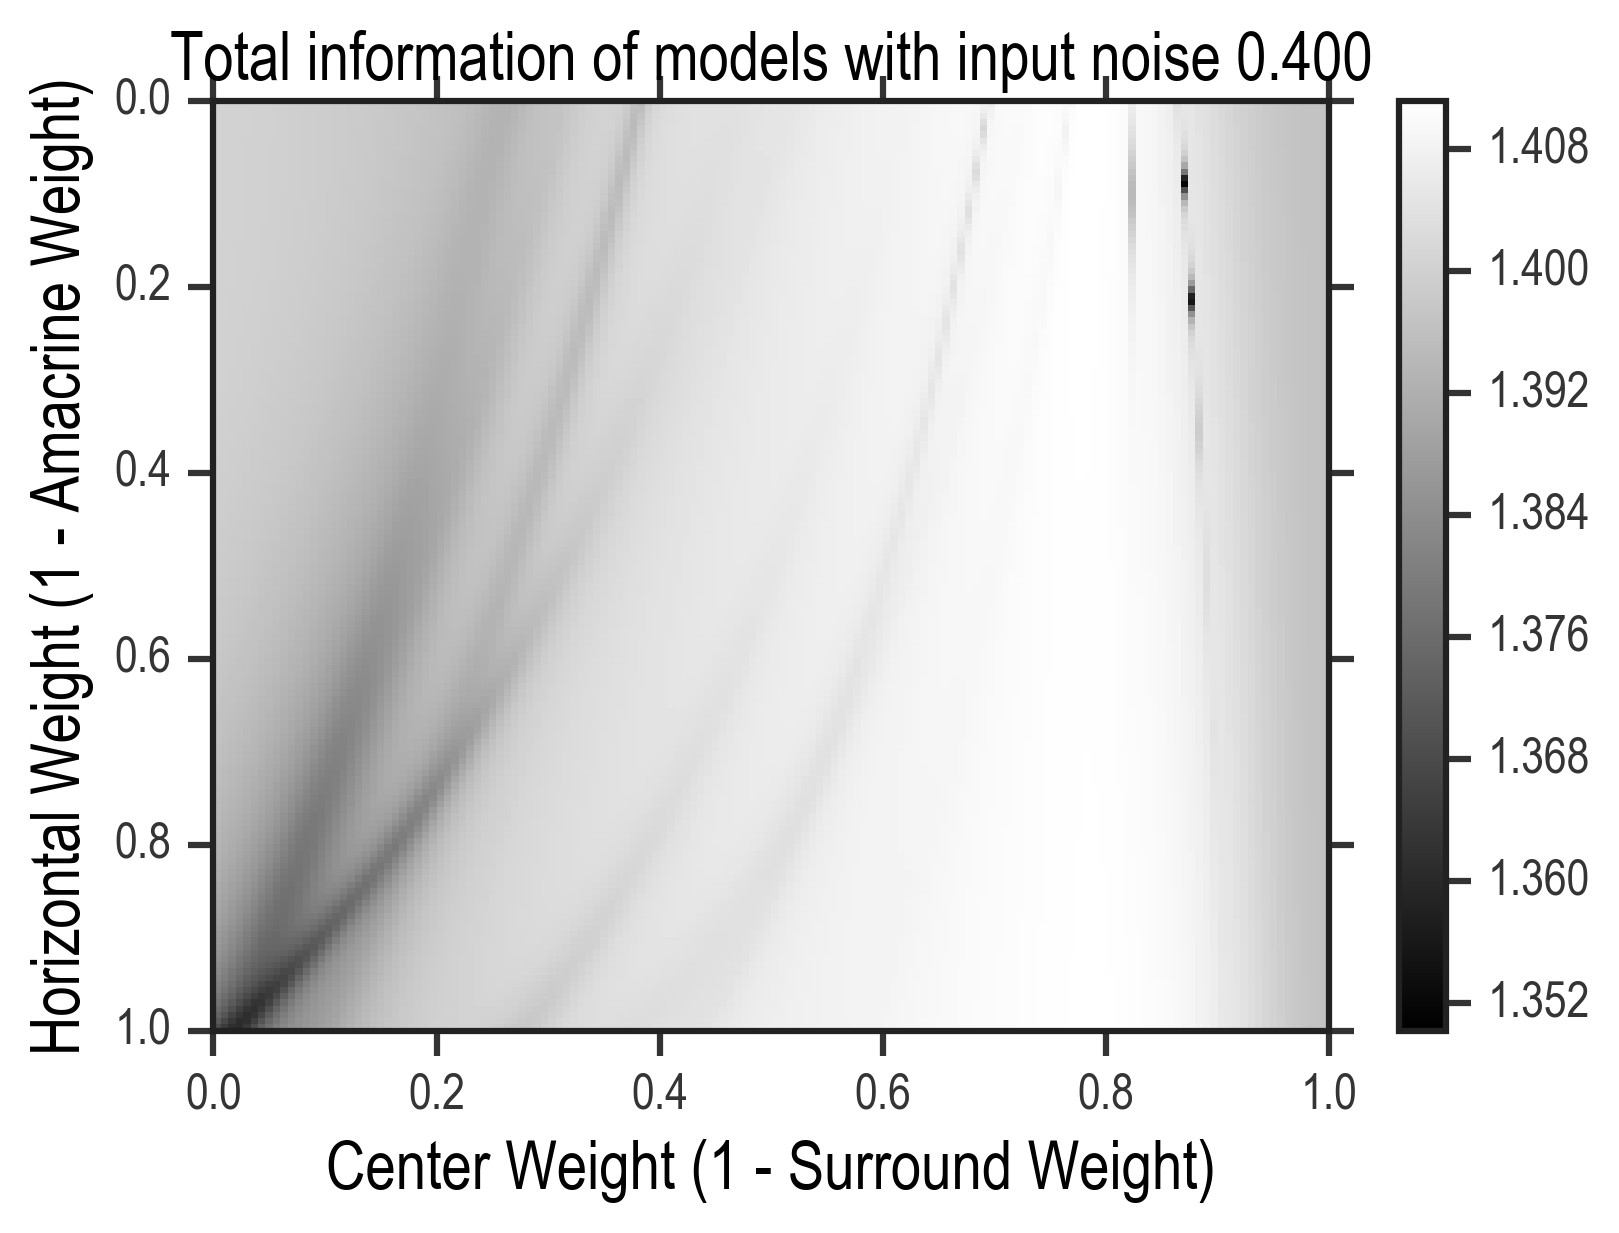

In [137]:
plt.imshow(info_colormaps_vs_noise_outersum[input_noises[-1]], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.title('Total information of models with input noise %0.3f' %input_noises[-1], fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)
# plt.xlim(0.8,1)

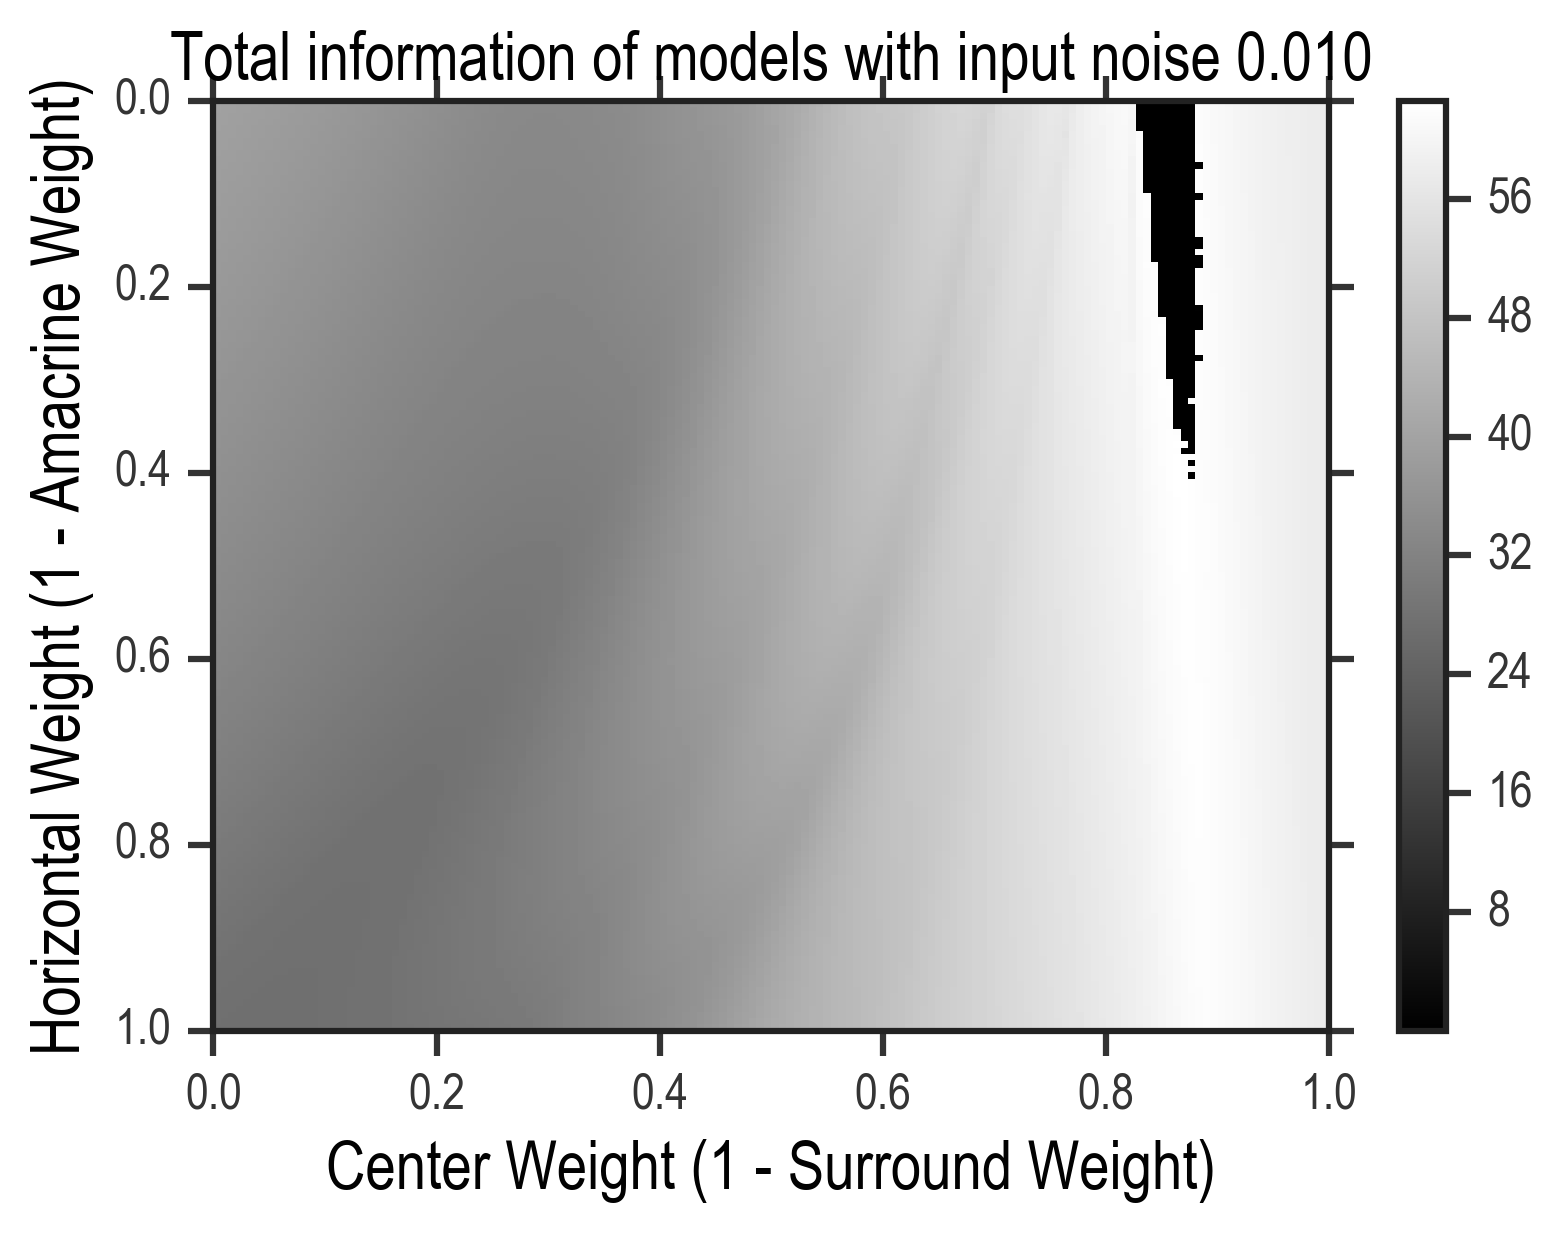

In [138]:
plt.imshow(info_colormaps_vs_noise_outersum[input_noises[0]], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.title('Total information of models with input noise %0.3f' %input_noises[0], fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)
# plt.xlim(0.8,1)

#### Why is MSE to ganglion cells so large? and why is the landscape flatter than we saw before?

In [140]:
input_noise = 0.12

In [180]:
info_color_map_innersum = np.zeros((resolution, resolution))
info_color_map_outersum = np.zeros((resolution, resolution))
mse_color_map_ganglion = np.zeros((resolution, resolution))
mse_color_map_ideal = np.zeros((resolution, resolution))
mse_color_map_ideal_hr = np.zeros((resolution, resolution))
output_variances = np.zeros((resolution, resolution))
signal_variances = np.zeros((resolution, resolution))
noise_variances = np.zeros((resolution, resolution))
snrs = np.zeros((resolution, resolution))
filter_consts = np.zeros((resolution, resolution))
pablo_snrs = np.zeros((resolution, resolution))


# Solve for ideal filter assuming a signal at highres or at the sampling rate of our cells
ideal_filt = unique_soln(signal**2, input_noise, output_noise)
ideal_filt_highres = unique_soln(signal_highres**2, input_noise, output_noise)

ideal_filt_interp = interp1d(freqs, ideal_filt, kind='slinear', bounds_error=False, fill_value=[0])
ideal_filt_hr_interp = interp1d(freqs_highres, ideal_filt_highres, kind='slinear',
                               bounds_error=False, fill_value=[0])

ideal = ideal_filt_interp(freqs_padded)
ideal_hr = ideal_filt_hr_interp(freqs_padded)

# Constrain ideal variance
def constrain_filt_var(filt_const):
    filt_variance = get_output_var(input_noise, output_noise, signal_padded, filt_const*ideal)
    return (target_variance - filt_variance)**2  

ideal_filt_const_opt = scipy.optimize.minimize(constrain_filt_var, 0.4)
ideal_filt_const = abs(ideal_filt_const_opt['x'])
    
def constrain_filt_var(filt_const):
    filt_variance = get_output_var(input_noise, output_noise, signal_padded, filt_const*ideal_hr)
    return (target_variance - filt_variance)**2

ideal_filt_hr_const_opt = scipy.optimize.minimize(constrain_filt_var, 0.4)
ideal_filt_hr_const = abs(ideal_filt_hr_const_opt['x'])

# Apply filter constants
ideal *= ideal_filt_const
ideal_hr *= ideal_filt_hr_const

for idh,hw in tqdm(enumerate(horz_weights)):
    for idc,cw in enumerate(center_weights):
        rf_model = rf_cached(hw, cw)
        rf_filt = abs(np.fft.rfft(rf_model, n=2*len(rf_model)-1))

        def constrain_filt_var(filt_const):
            filt_variance = get_output_var(input_noise, output_noise, signal_padded, filt_const*rf_filt)
            return (target_variance - filt_variance)**2

        filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
        filt_const = abs(filt_const_opt['x'])
        filter_consts[idh,idc] = filt_const

        # compute total information for this particular model
        snr = get_snr(input_noise, output_noise, signal_padded, filt_const*rf_filt)
        pablo_snr = get_snr(input_noise, output_noise, signal_padded, filt_const*rf_filt, mode='std')
        signal_vars = get_signal_var(signal_padded, filt_const*rf_filt, total_var=False)
        noise_vars = get_noise_var(input_noise, output_noise, filt_const*rf_filt, total_var=False)
        info_color_map_innersum[idh,idc] = 0.5*np.log2(1 + snr)
        info_color_map_outersum[idh,idc] = 0.5*np.sum(np.log2(1 + signal_vars/noise_vars))
        signal_variances[idh,idc] = np.sum(signal_vars)
        noise_variances[idh,idc] = np.sum(noise_vars)
        output_variances[idh,idc] = np.sum(signal_vars + noise_vars)
        snrs[idh,idc] = snr
        pablo_snrs[idh,idc] = pablo_snr

        # compute the MSE difference between this model filter and the ideal filter
        mse_color_map_ganglion[idh,idc] = np.mean((ganglion_padded_constrained - filt_const*rf_filt)**2)
        mse_color_map_ideal[idh,idc] = np.mean((ideal - filt_const*rf_filt)**2)
        mse_color_map_ideal_hr[idh,idc] = np.mean((ideal_hr - filt_const*rf_filt)**2)

The relative error from this choice of Lagrangian multiplier is 9.41969417817e-08.
The relative error from this choice of Lagrangian multiplier is 3.33258593648e-07.


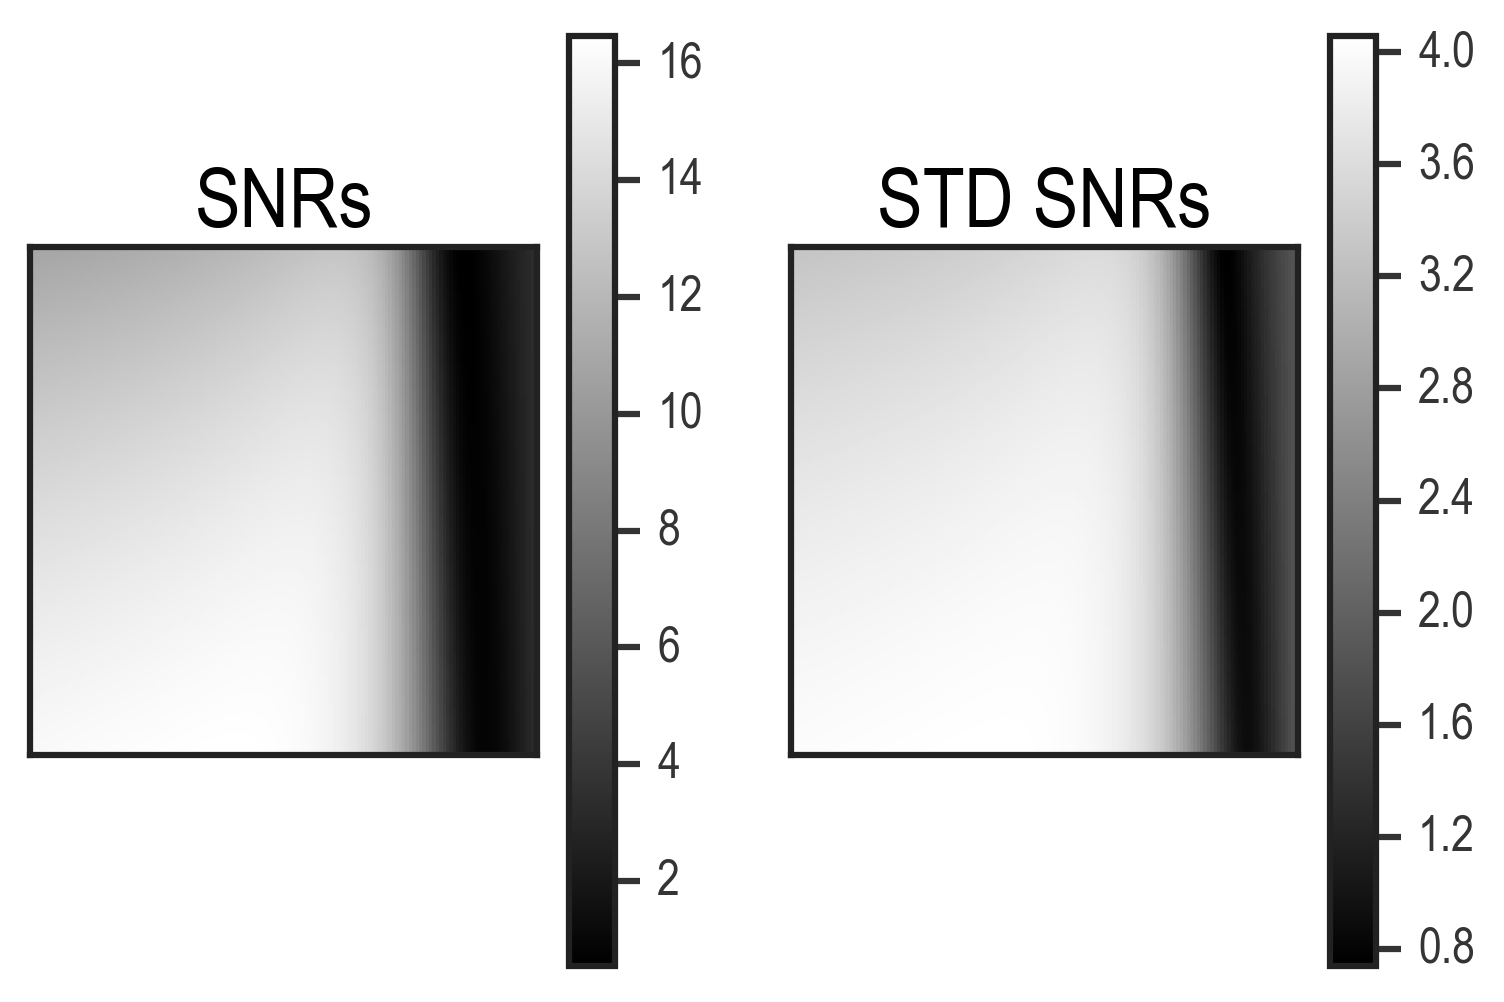

In [181]:
plt.subplot(121)
plt.imshow(snrs)
plt.xticks([])
plt.yticks([])
plt.title('SNRs')
plt.colorbar()

plt.subplot(122)
plt.imshow(pablo_snrs)
plt.xticks([])
plt.yticks([])
plt.title('STD SNRs')
plt.colorbar()

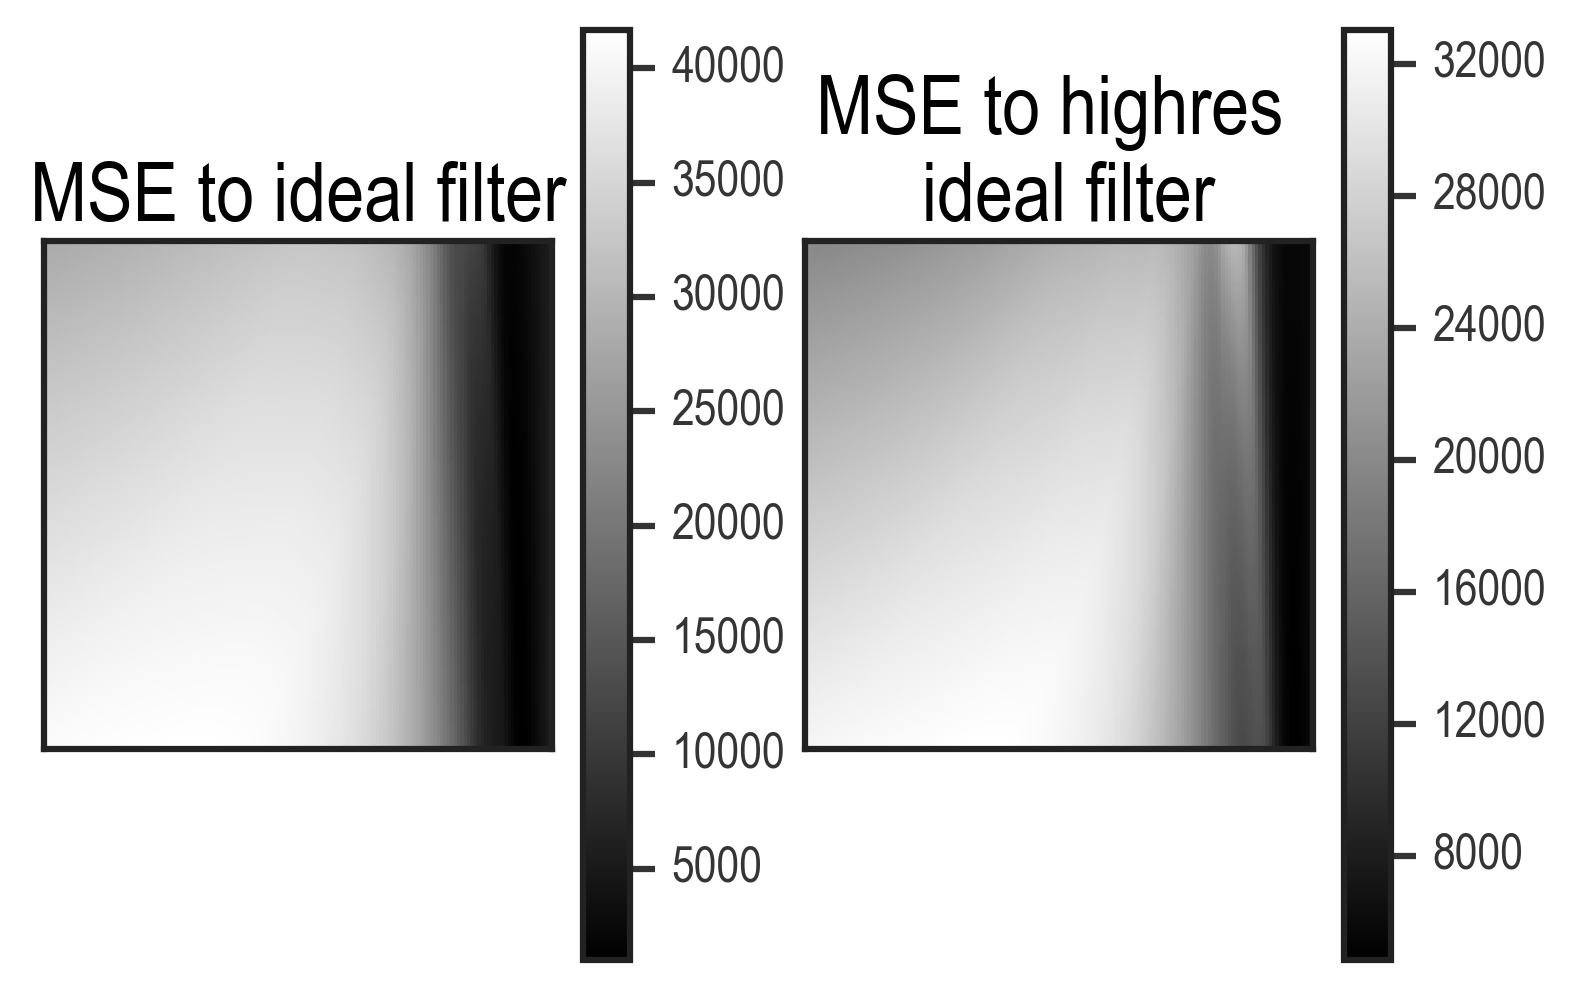

In [176]:
plt.subplot(121)
plt.imshow(mse_color_map_ideal)
plt.title('MSE to ideal filter')
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.subplot(122)
plt.imshow(mse_color_map_ideal_hr)
plt.title('MSE to highres \n ideal filter')
plt.xticks([])
plt.yticks([])
plt.colorbar()

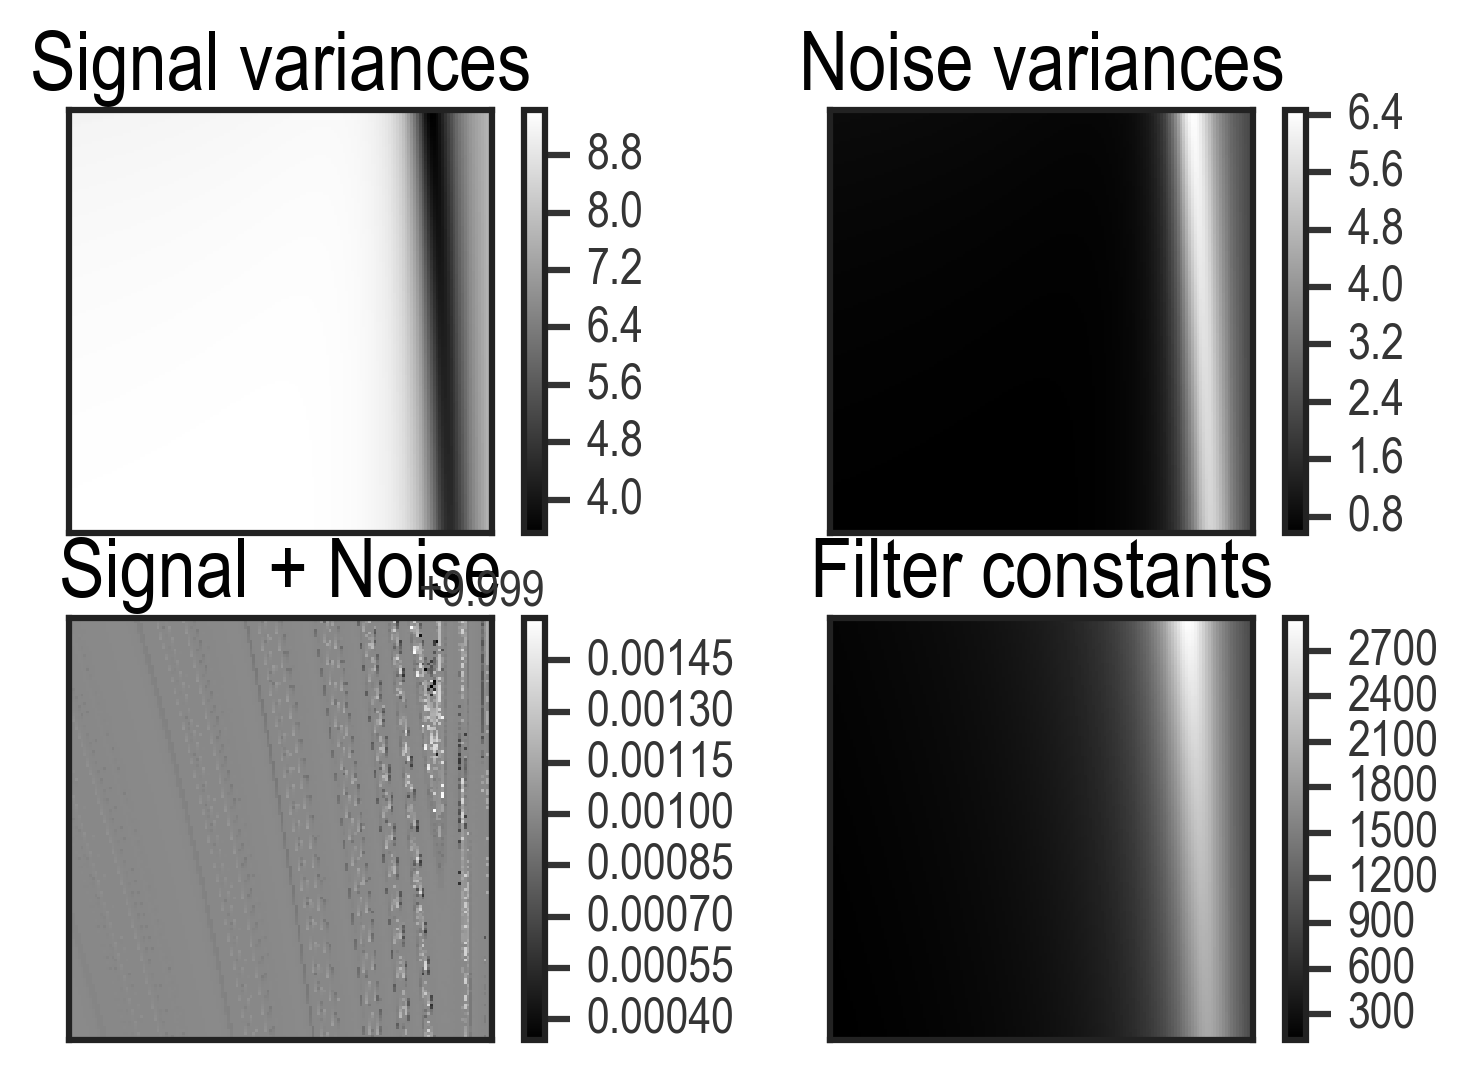

In [167]:
plt.subplot(221)
plt.imshow(signal_variances)
plt.title('Signal variances')
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.subplot(222)
plt.imshow(noise_variances)
plt.title('Noise variances')
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.subplot(223)
plt.imshow(output_variances)
plt.title('Signal + Noise')
plt.xticks([])
plt.yticks([])
plt.colorbar()

plt.subplot(224)
plt.imshow(filter_consts)
plt.title('Filter constants')
plt.xticks([])
plt.yticks([])
plt.colorbar()

Investigate for a few rf params

In [168]:
hw = 1.0
cw = 0.93

rf_model = rf_cached(hw, cw)
rf_filt = abs(np.fft.rfft(rf_model, n=2*len(rf_model)-1))

def constrain_filt_var(filt_const):
    filt_variance = get_output_var(input_noise, output_noise, signal_padded, filt_const*rf_filt)
    return (target_variance - filt_variance)**2

filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
filt_const = abs(filt_const_opt['x'])

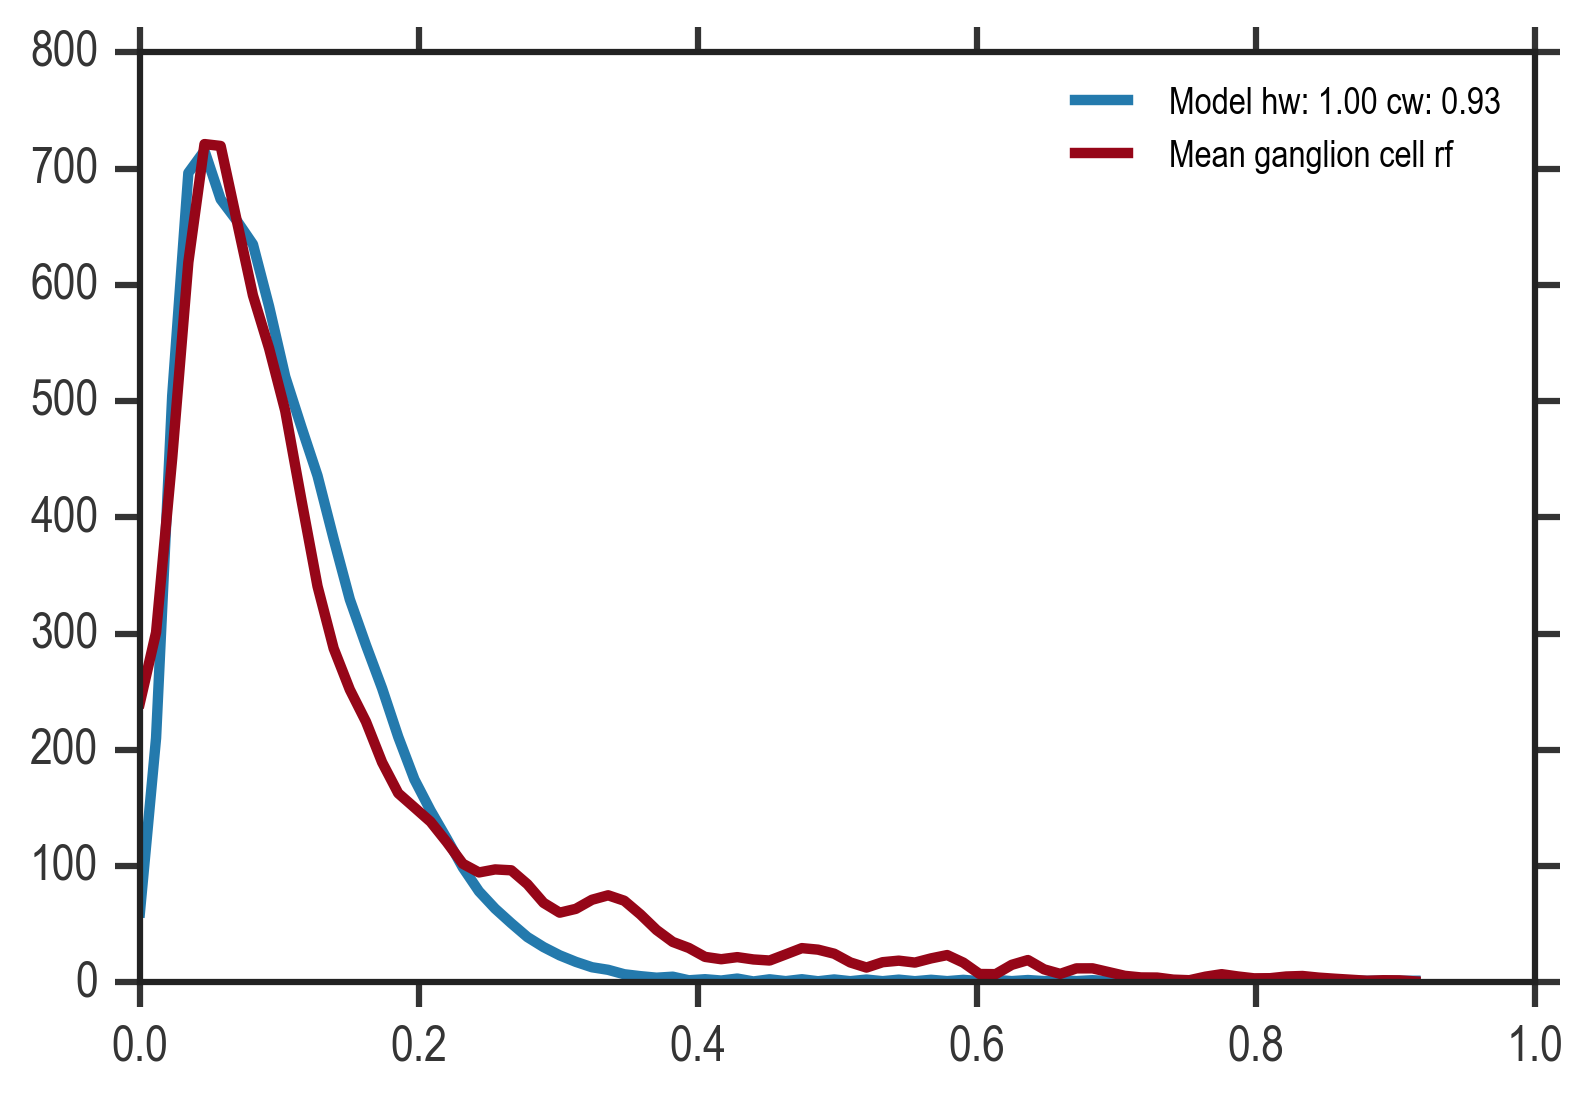

In [170]:
plt.plot(freqs_padded, filt_const * rf_filt, label='Model hw: %0.2f cw: %0.2f' %(hw,cw))
plt.plot(freqs_padded, ganglion_padded_constrained, label='Mean ganglion cell rf')
# plt.plot(freqs_padded, ideal_filt_const*ideal, label='ideal')
# plt.plot(freqs_padded, ideal_filt_hr_const*ideal_hr, label='ideal highres')
plt.legend(frameon=False, fontsize=9)

In [178]:
np.mean((ganglion_padded_constrained - filt_const*rf_filt)**2)

1632.5595789649913

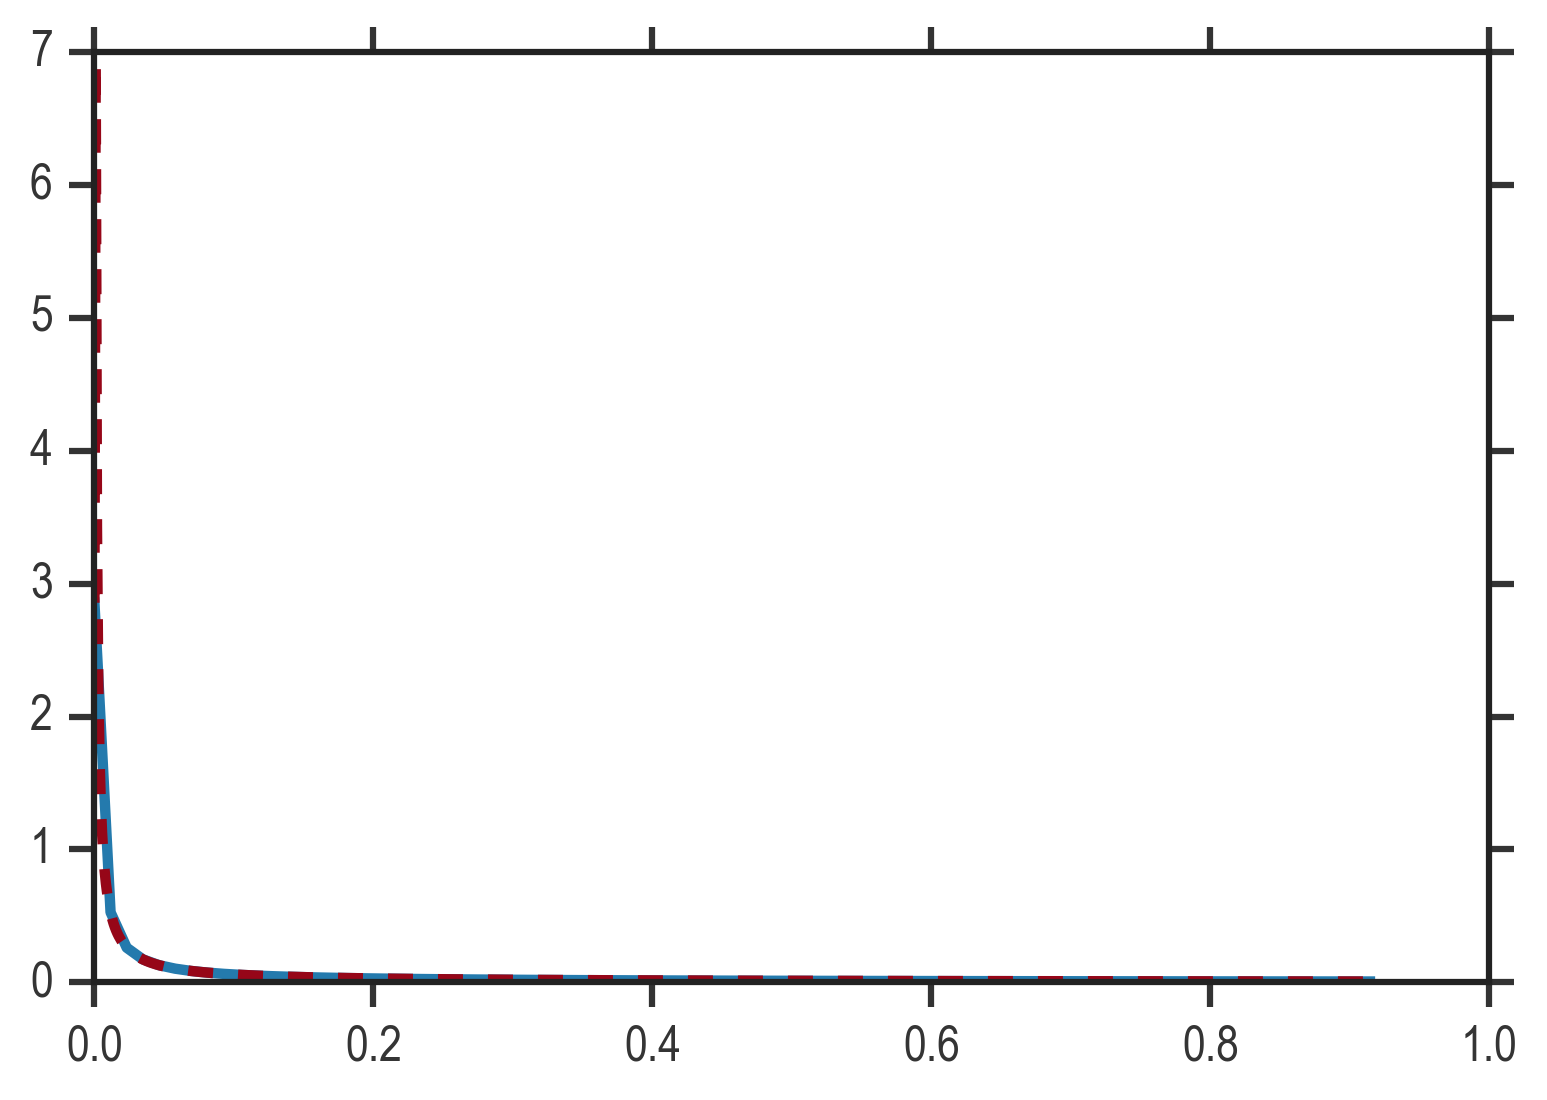

In [211]:
plt.plot(freqs_padded, signal_padded)
plt.plot(freqs_highres, signal_highres, '--')

## Constrain SNR

In [212]:
x = np.linspace(0,.4,20)
y = 2.06 + 15.1*x

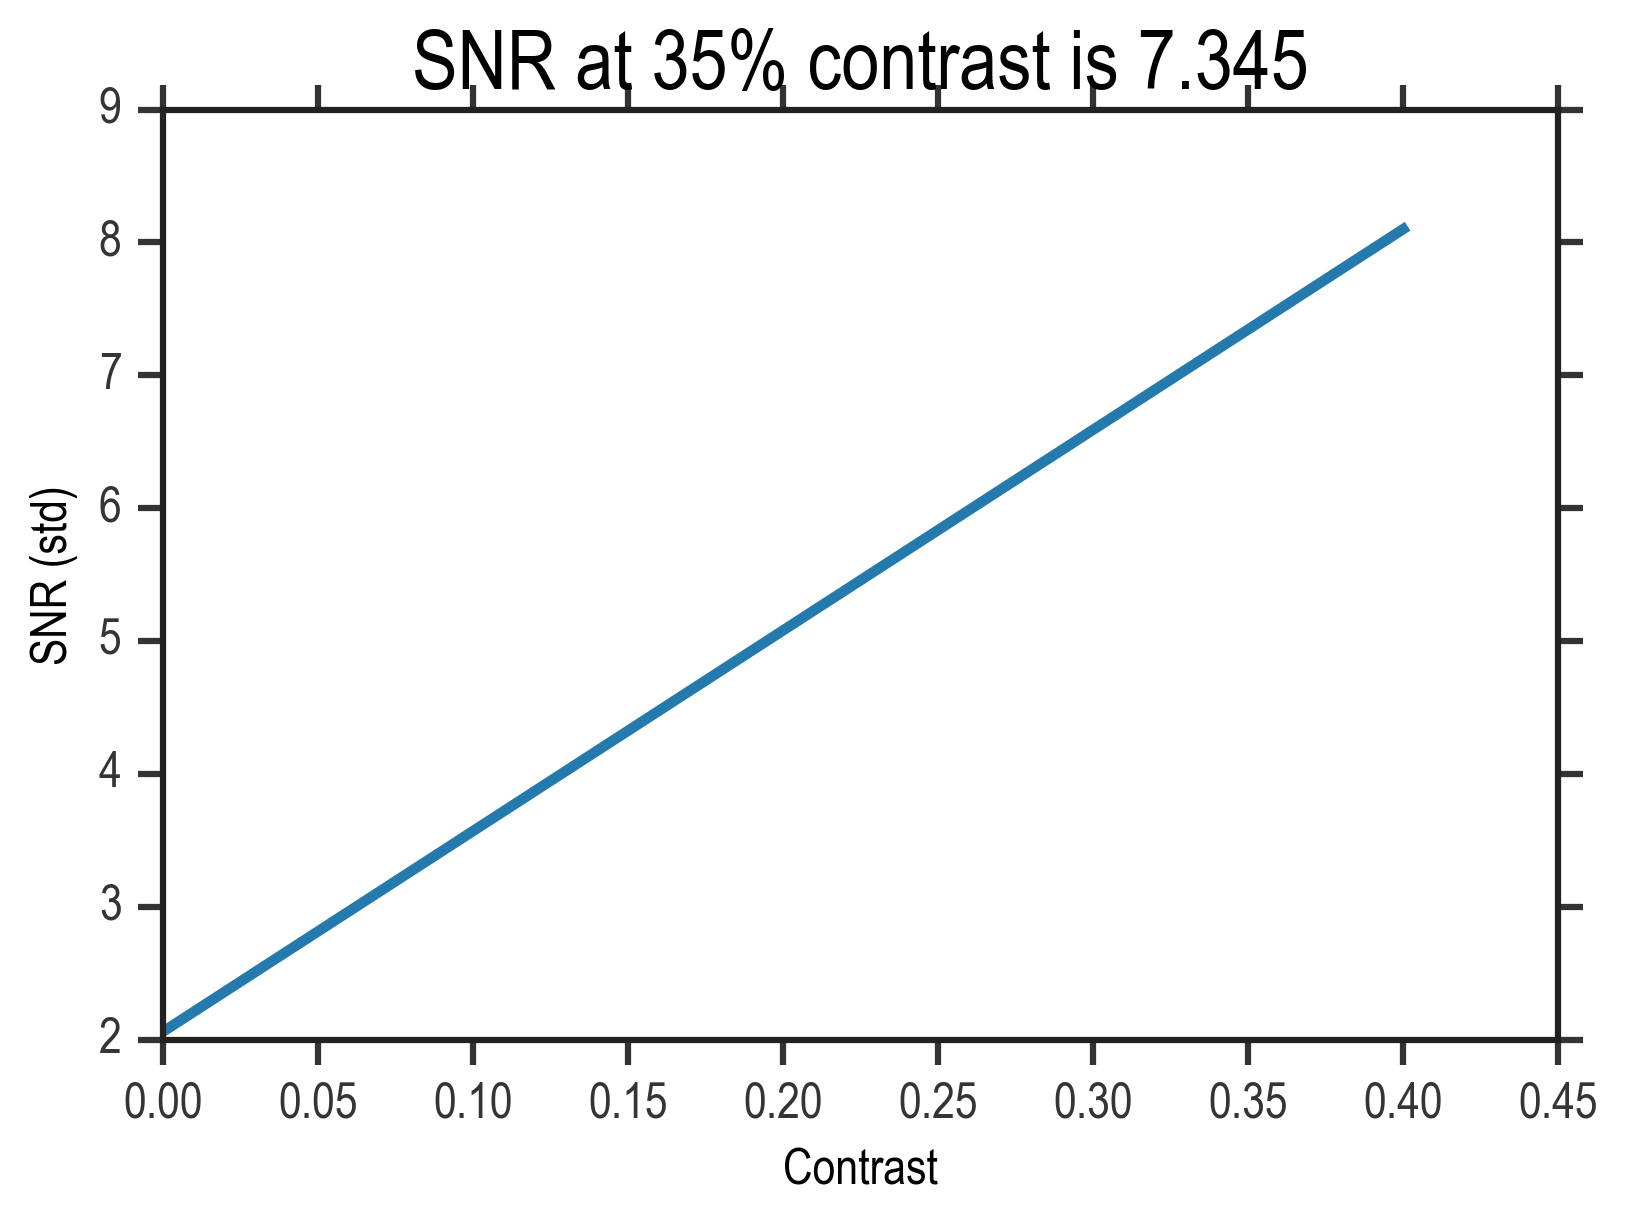

In [214]:
plt.plot(x, y)
plt.title('SNR at 35%% contrast is %0.3f' %(2.06 + 15.1*0.35))
plt.xlabel('Contrast')
plt.ylabel('SNR (std)')

In [216]:
target_snr_std = 7.345
# def find_params(input_noise, output_noise, target_variance, filt_const):
input_noises = np.logspace(-3,2,10)
output_noises = np.logspace(-3,2,10)
target_variances = [0.1, 1., 10., 100.]
init_filt_const = 0.4

ganglion_consts = np.zeros((len(input_noises), len(output_noises), len(target_variances)))
snr_stds = np.zeros((len(input_noises), len(output_noises), len(target_variances)))

for i,input_noise in tqdm(enumerate(input_noises)):
    for o,output_noise in enumerate(output_noises):
        for t,target_variance in enumerate(target_variances):
            
            def constrain_output_var(filt_const):
                output_var = get_output_var(input_noise, output_noise, signal_padded, filt_const*ganglion_padded)
                return np.mean((target_variance - output_var)**2)
            
            filt_const_opt = scipy.optimize.minimize(constrain_output_var, init_filt_const)
            filt_const = abs(filt_const_opt['x'])
            ganglion_consts[i,o,t] = filt_const
            
            snr_std = get_snr(input_noise, output_noise, signal_padded, filt_const*ganglion_padded, mode='std')
            snr_stds[i,o,t] = snr_std

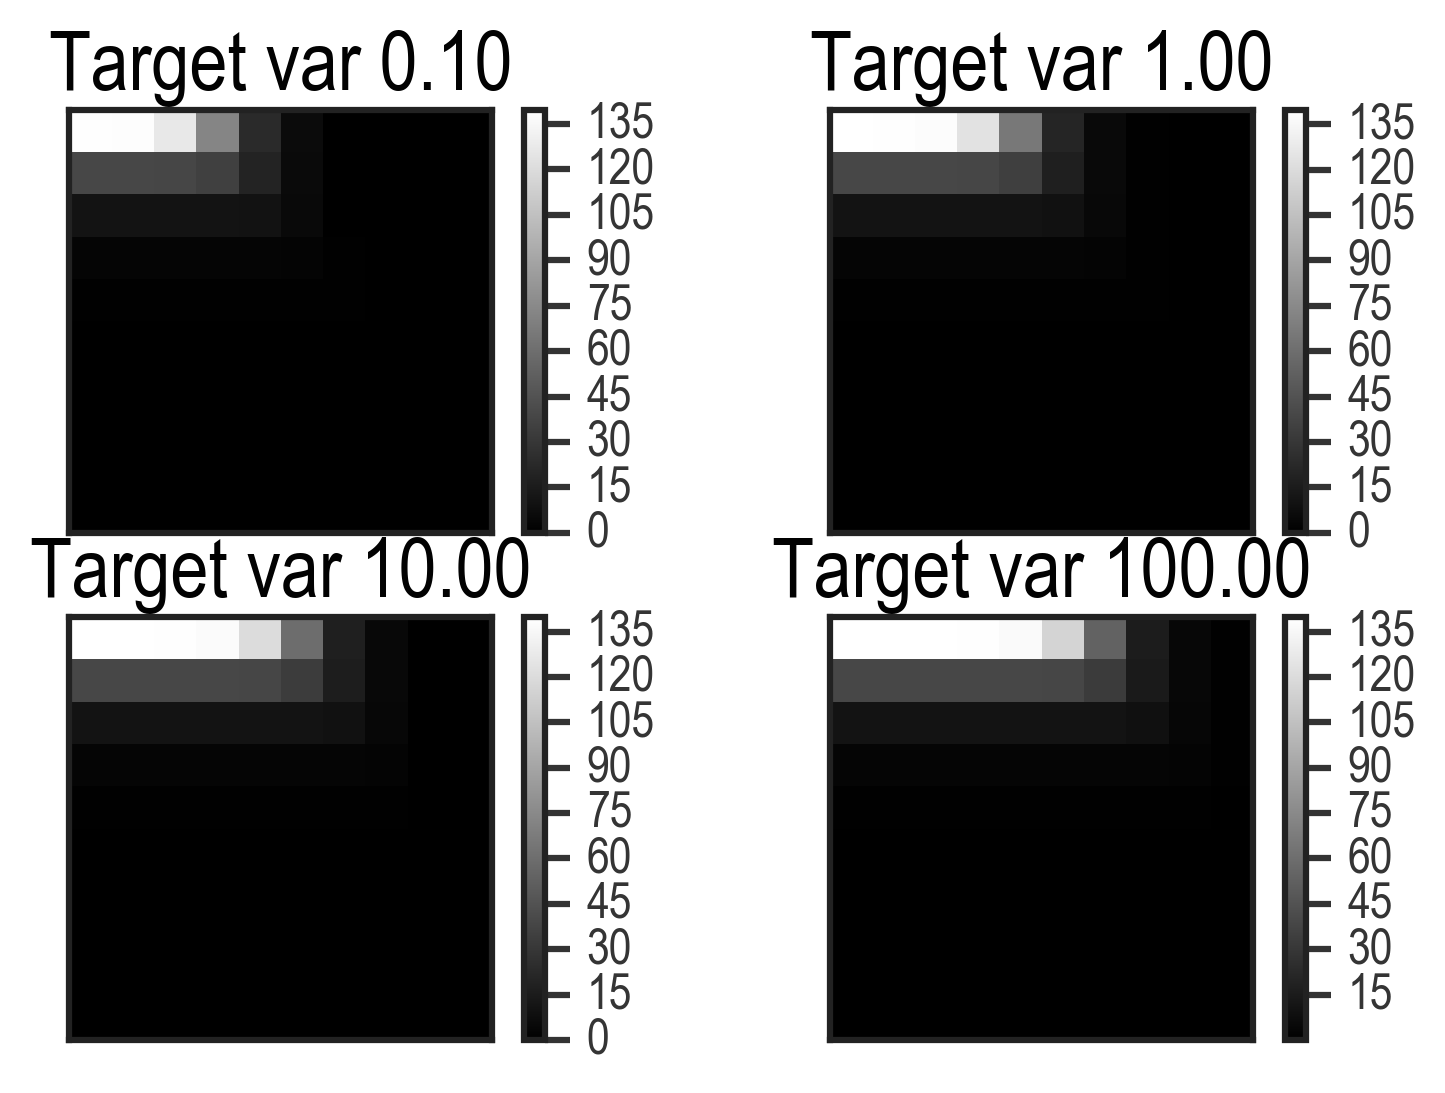

In [223]:
for t in range(4):
    subplot_id = '22%d' %(t+1)
    plt.subplot(subplot_id)
    plt.imshow(snr_stds[:,:,t])
    plt.title('Target var %0.2f' %target_variances[t])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

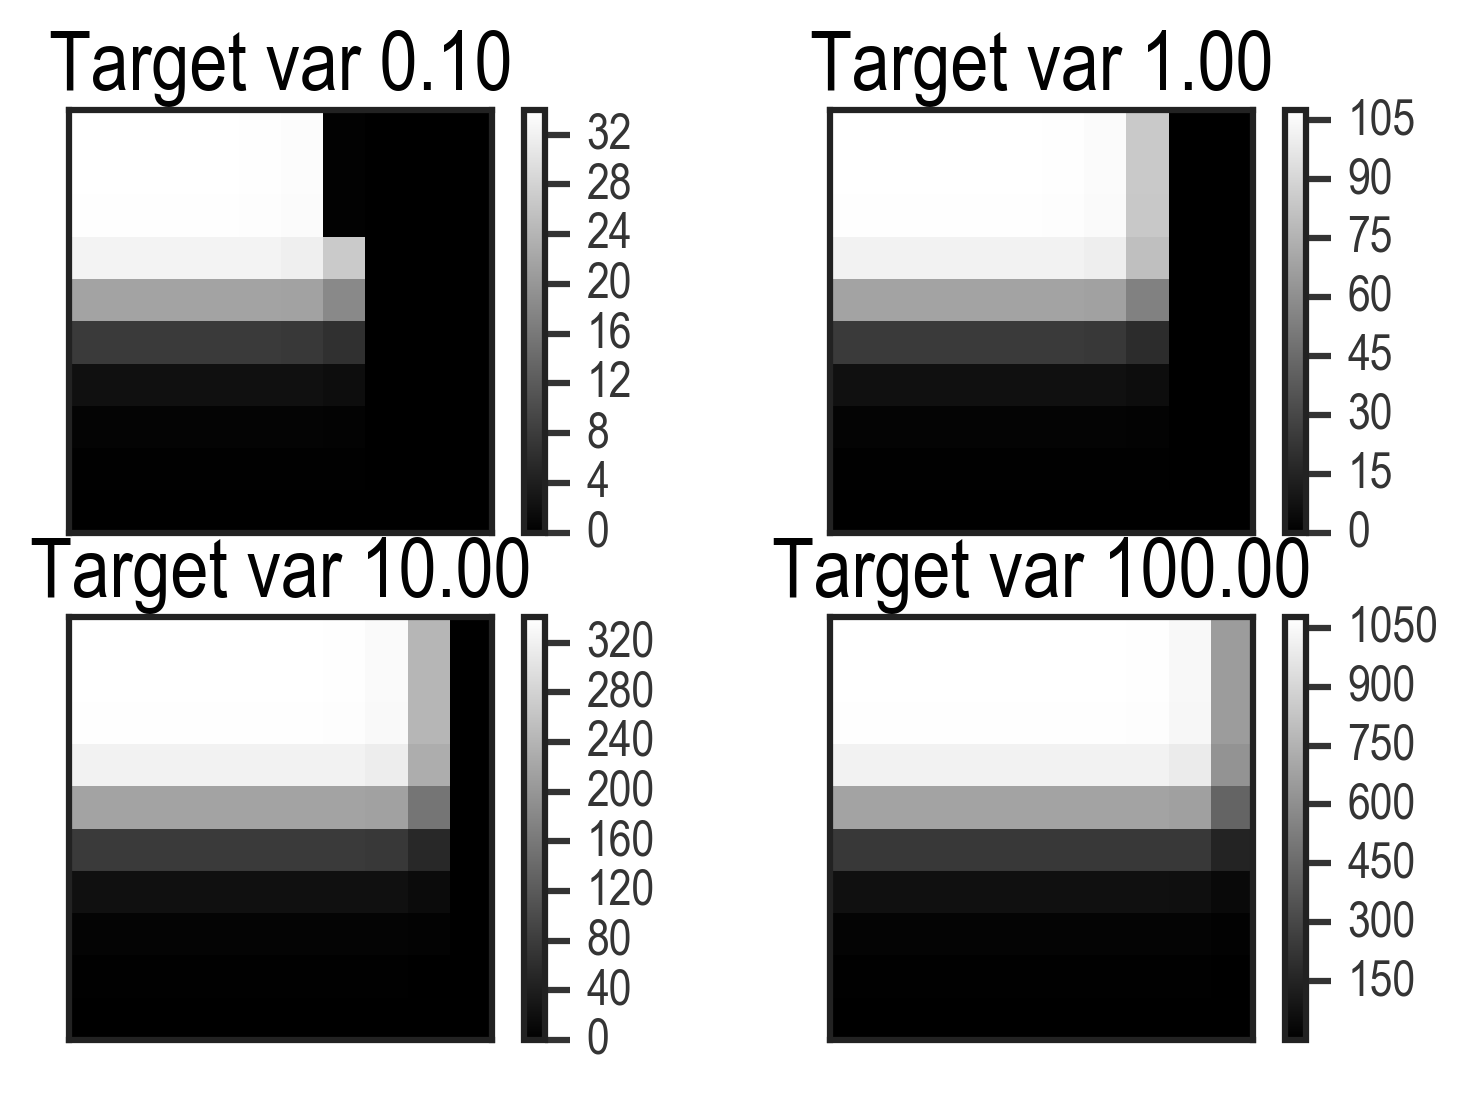

In [224]:
for t in range(4):
    subplot_id = '22%d' %(t+1)
    plt.subplot(subplot_id)
    plt.imshow(ganglion_consts[:,:,t])
    plt.title('Target var %0.2f' %target_variances[t])
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()

## Okay, so target variance doesn't matter.

In [237]:
target_snr_std = 7.345
# def find_params(input_noise, output_noise, target_variance, filt_const):
input_noises = np.logspace(-3,2,100)
output_noises = np.logspace(-3,2,100)
target_variance = 100.
init_filt_const = 0.4

ganglion_consts = np.zeros((len(input_noises), len(output_noises)))
snr_stds = np.zeros((len(input_noises), len(output_noises)))
output_vars = np.zeros((len(input_noises), len(output_noises)))

for i,input_noise in tqdm(enumerate(input_noises)):
    for o,output_noise in enumerate(output_noises):            
        def constrain_output_var(filt_const):
            output_var = get_output_var(input_noise, output_noise, signal_padded, filt_const*ganglion_padded)
            return np.mean((target_variance - output_var)**2)

        filt_const_opt = scipy.optimize.minimize(constrain_output_var, init_filt_const)
        filt_const = abs(filt_const_opt['x'])
        ganglion_consts[i,o] = filt_const
                       
        output_var = get_output_var(input_noise, output_noise, signal_padded, filt_const*ganglion_padded)
        output_vars[i,o] = output_var

        snr_std = get_snr(input_noise, output_noise, signal_padded, filt_const*ganglion_padded, mode='std')
        snr_stds[i,o] = snr_std

/usr/local/lib/python3.5/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


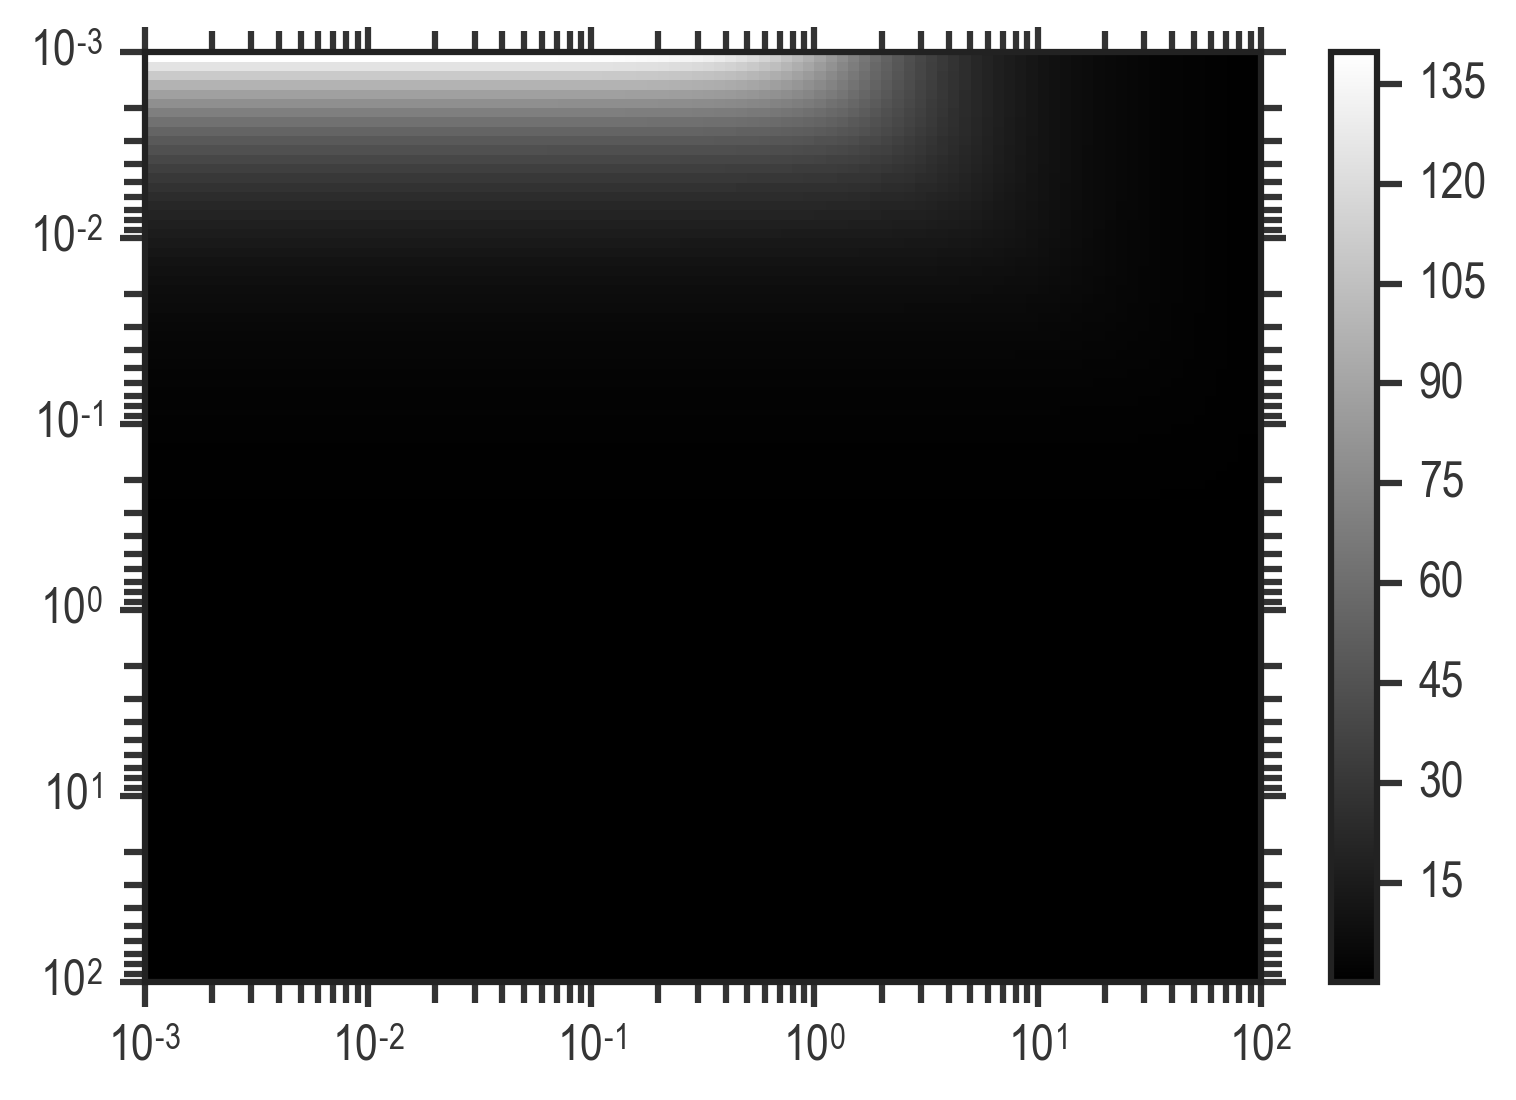

In [244]:
plt.imshow(snr_stds, extent=(output_noises[0], output_noises[-1], input_noises[-1], input_noises[0]),
          aspect='auto')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

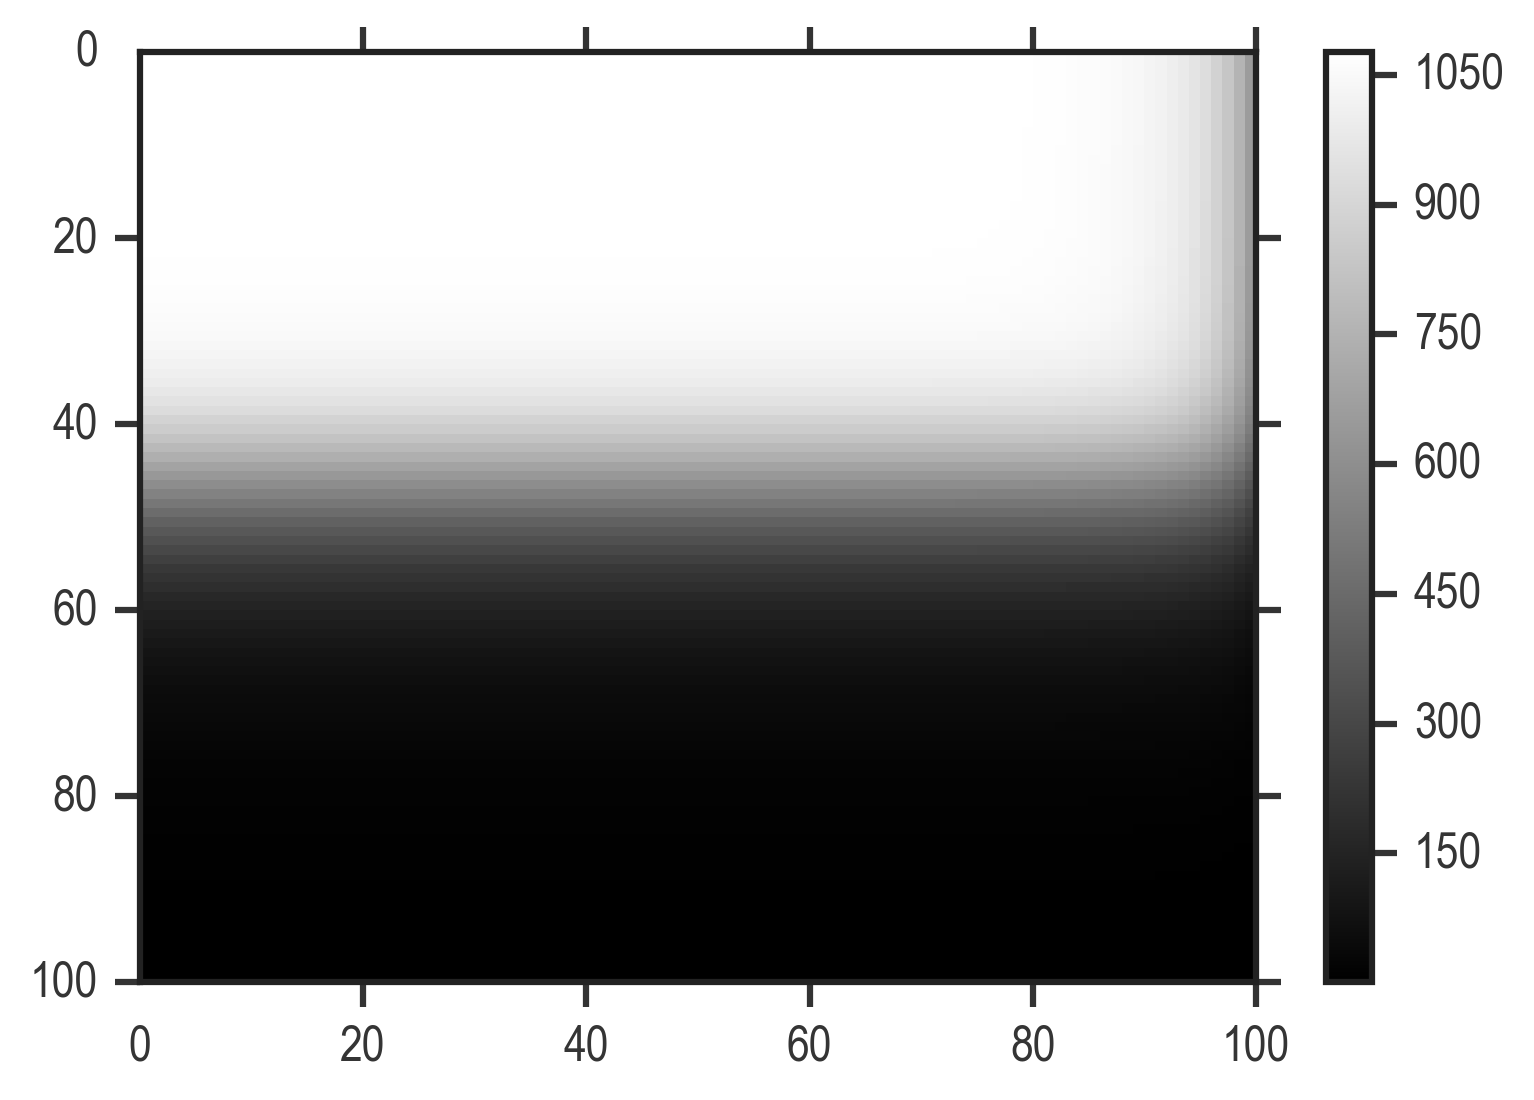

In [240]:
plt.imshow(ganglion_consts, extent=(output_noises[0], output_noises[-1], input_noises[-1], input_noises[0]),
          aspect='auto')
plt.colorbar()

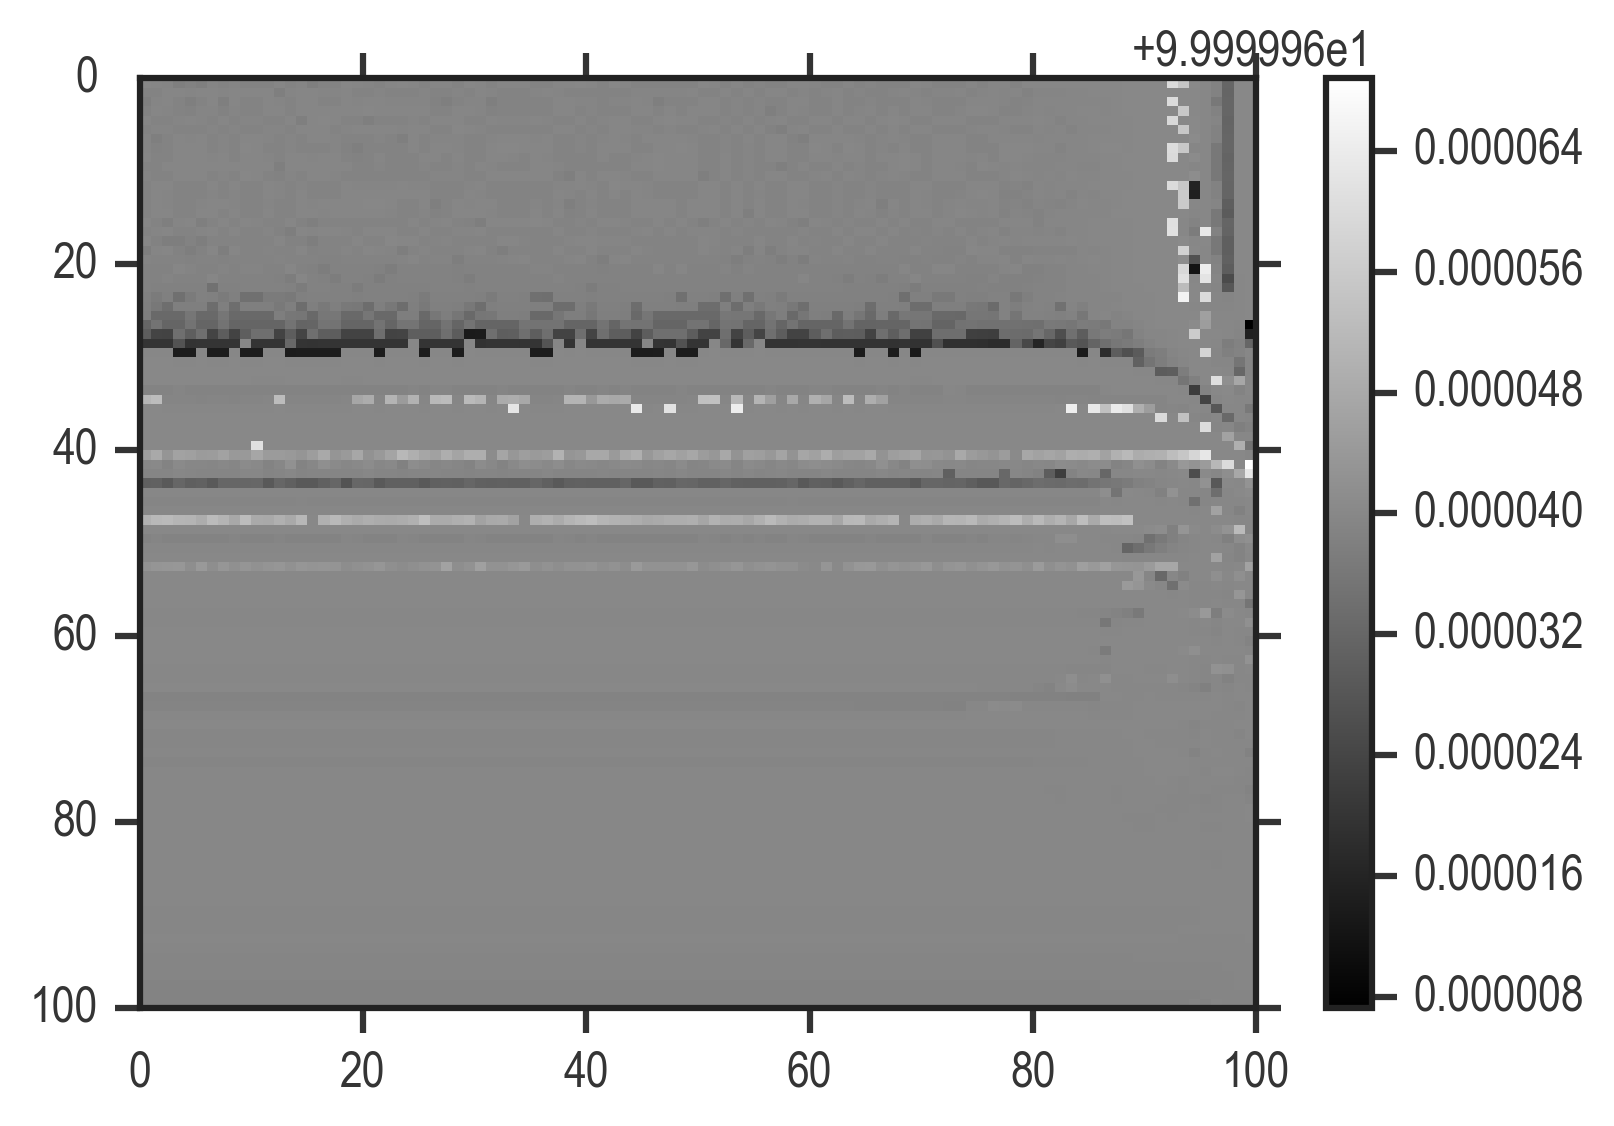

In [241]:
plt.imshow(output_vars, extent=(output_noises[0], output_noises[-1], input_noises[-1], input_noises[0]),
          aspect='auto')
plt.colorbar()

## Try linear spacing

In [245]:
target_snr_std = 7.345
# def find_params(input_noise, output_noise, target_variance, filt_const):
input_noises = np.linspace(0.01,2,100)
output_noises = np.linspace(0.01,2,100)
target_variance = 100.
init_filt_const = 0.4

ganglion_consts = np.zeros((len(input_noises), len(output_noises)))
snr_stds = np.zeros((len(input_noises), len(output_noises)))
output_vars = np.zeros((len(input_noises), len(output_noises)))

for i,input_noise in tqdm(enumerate(input_noises)):
    for o,output_noise in enumerate(output_noises):            
        def constrain_output_var(filt_const):
            output_var = get_output_var(input_noise, output_noise, signal_padded, filt_const*ganglion_padded)
            return np.mean((target_variance - output_var)**2)

        filt_const_opt = scipy.optimize.minimize(constrain_output_var, init_filt_const)
        filt_const = abs(filt_const_opt['x'])
        ganglion_consts[i,o] = filt_const
                       
        output_var = get_output_var(input_noise, output_noise, signal_padded, filt_const*ganglion_padded)
        output_vars[i,o] = output_var

        snr_std = get_snr(input_noise, output_noise, signal_padded, filt_const*ganglion_padded, mode='std')
        snr_stds[i,o] = snr_std

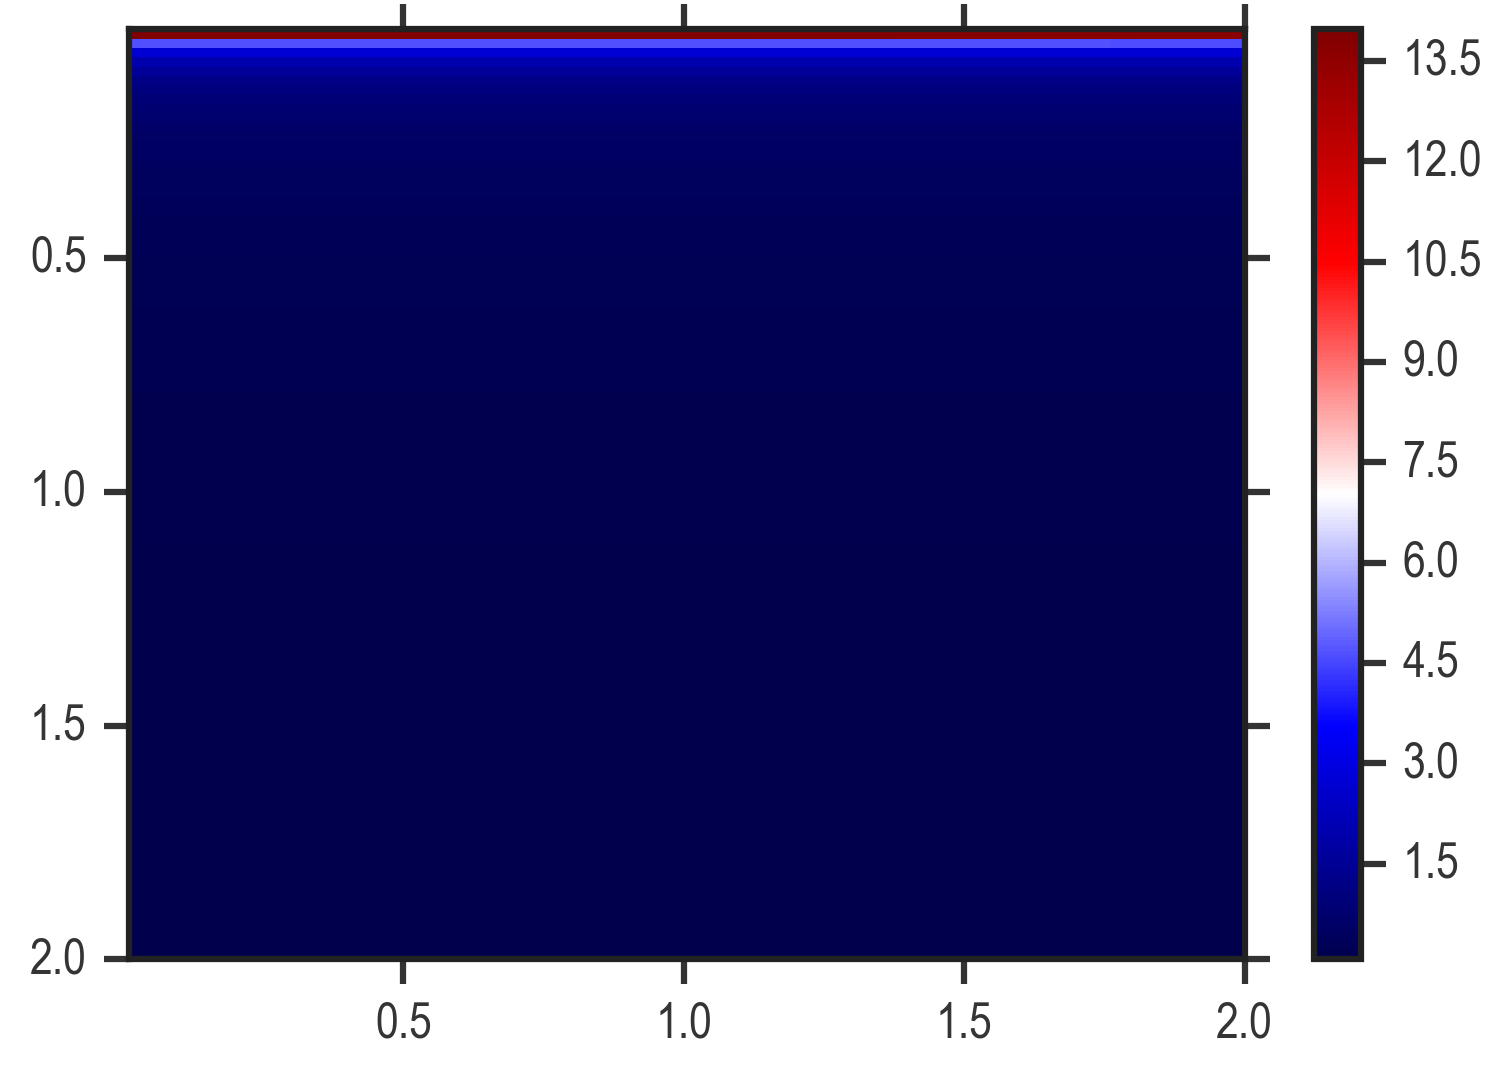

In [247]:
plt.imshow(snr_stds, extent=(output_noises[0], output_noises[-1], input_noises[-1], input_noises[0]),
          aspect='auto', cmap='seismic')
plt.colorbar()

In [328]:
target_snr_std = 7.345

def find_input_output_var(noises):
    input_noise, output_noise = noises
    
    def constrain_output_var(filt_const):
        output_var = get_output_var(input_noise, output_noise, signal_padded, filt_const*ganglion_padded)
        return np.mean((target_variance - output_var)**2)

    filt_const_opt = scipy.optimize.minimize(constrain_output_var, init_filt_const)
    filt_const = abs(filt_const_opt['x'])

    snr_std = get_snr(input_noise, output_noise, signal_padded, filt_const*ganglion_padded, mode='std')

    return (target_snr_std - snr_std)**2

res = minimize(find_input_output_var, [0.12, 0.2])

If you play around with the initial conditions, the SNR is EXTREMELY sensitive to input noise, and virtually unsensitive to output noise. This is because we're multiplying input noise by a very large number (the filter) and so the relative magnitude of the output noise is relatively tiny. So you could increase the output noise by an order of magnitude and it wouldn't change the SNR much.

In [329]:
res

      fun: 8.272980573390089e-12
 hess_inv: array([[  3.35524790e-06,  -1.00394046e-05],
       [ -1.00394046e-05,   9.99999603e-01]])
      jac: array([  5.15009598e-08,  -3.95085781e-08])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 4
     njev: 11
   status: 0
  success: True
        x: array([ 0.01902322,  0.19999909])

In [330]:
input_noise, output_noise = res.x

In [331]:
def constrain_output_var(filt_const):
    output_var = get_output_var(input_noise, output_noise, signal_padded, filt_const*ganglion_padded)
    return np.mean((target_variance - output_var)**2)

filt_const_opt = scipy.optimize.minimize(constrain_output_var, init_filt_const)
filt_const = abs(filt_const_opt['x'])

In [332]:
filt_const

array([ 1066.36493866])

In [333]:
get_output_var(input_noise, 0.1*output_noise, signal_padded, filt_const*ganglion_padded)

99.999750304010092

In [334]:
get_output_var(input_noise, 10*output_noise, signal_padded, filt_const*ganglion_padded)

100.02474658899207

In [335]:
get_snr(input_noise, output_noise, signal_padded, filt_const*ganglion_padded, mode='std')

7.3450028762789454

In [336]:
get_snr(input_noise, output_noise, signal_padded, filt_const*ganglion_padded, mode='variance')

53.949067252545959

In [399]:
ideal_filter_high_output_noise = unique_soln(signal_padded**2, input_noise, 10*output_noise)
ideal_filter_low_output_noise = unique_soln(signal_padded**2, input_noise, 0.1*output_noise)

The relative error from this choice of Lagrangian multiplier is 8.93420956953e-07.
The relative error from this choice of Lagrangian multiplier is 4.43261623562e-08.


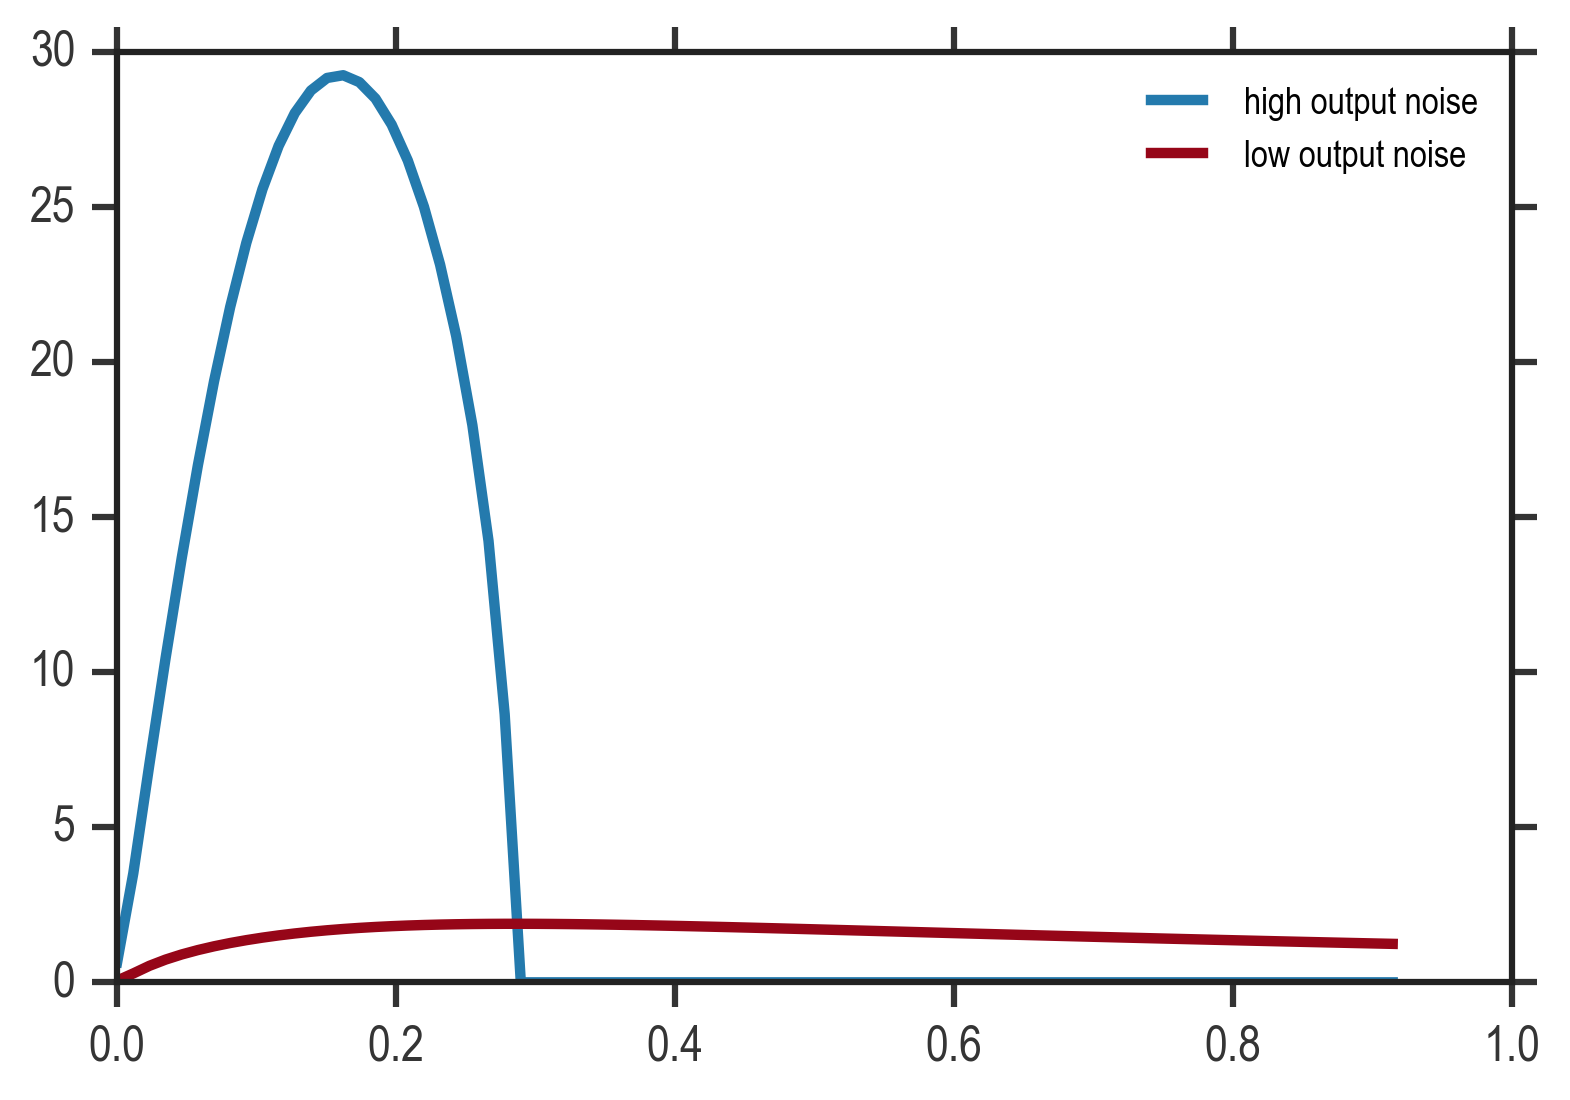

In [400]:
plt.plot(freqs_padded, ideal_filter_high_output_noise, label='high output noise')
plt.plot(freqs_padded, ideal_filter_low_output_noise, label='low output noise')
plt.legend(frameon=False, fontsize=9)

In [380]:
r0 = signal_padded**2
r = signal_padded**2 + input_noise**2

In [393]:
lam, relErr = get_lambda(r0, input_noise, 10*output_noise)

In [394]:
lam

array([ 3.73459322])

In [383]:
blah = unique_soln(r0, input_noise, 10*output_noise)

The relative error from this choice of Lagrangian multiplier is 6.87960940655e-08.


In [395]:
f = ((1. / input_noise**2) * (.5 * r0/r * (1 + np.sqrt(1 + (2 * lam * input_noise**2)/r0)) - 1)).astype(complex)

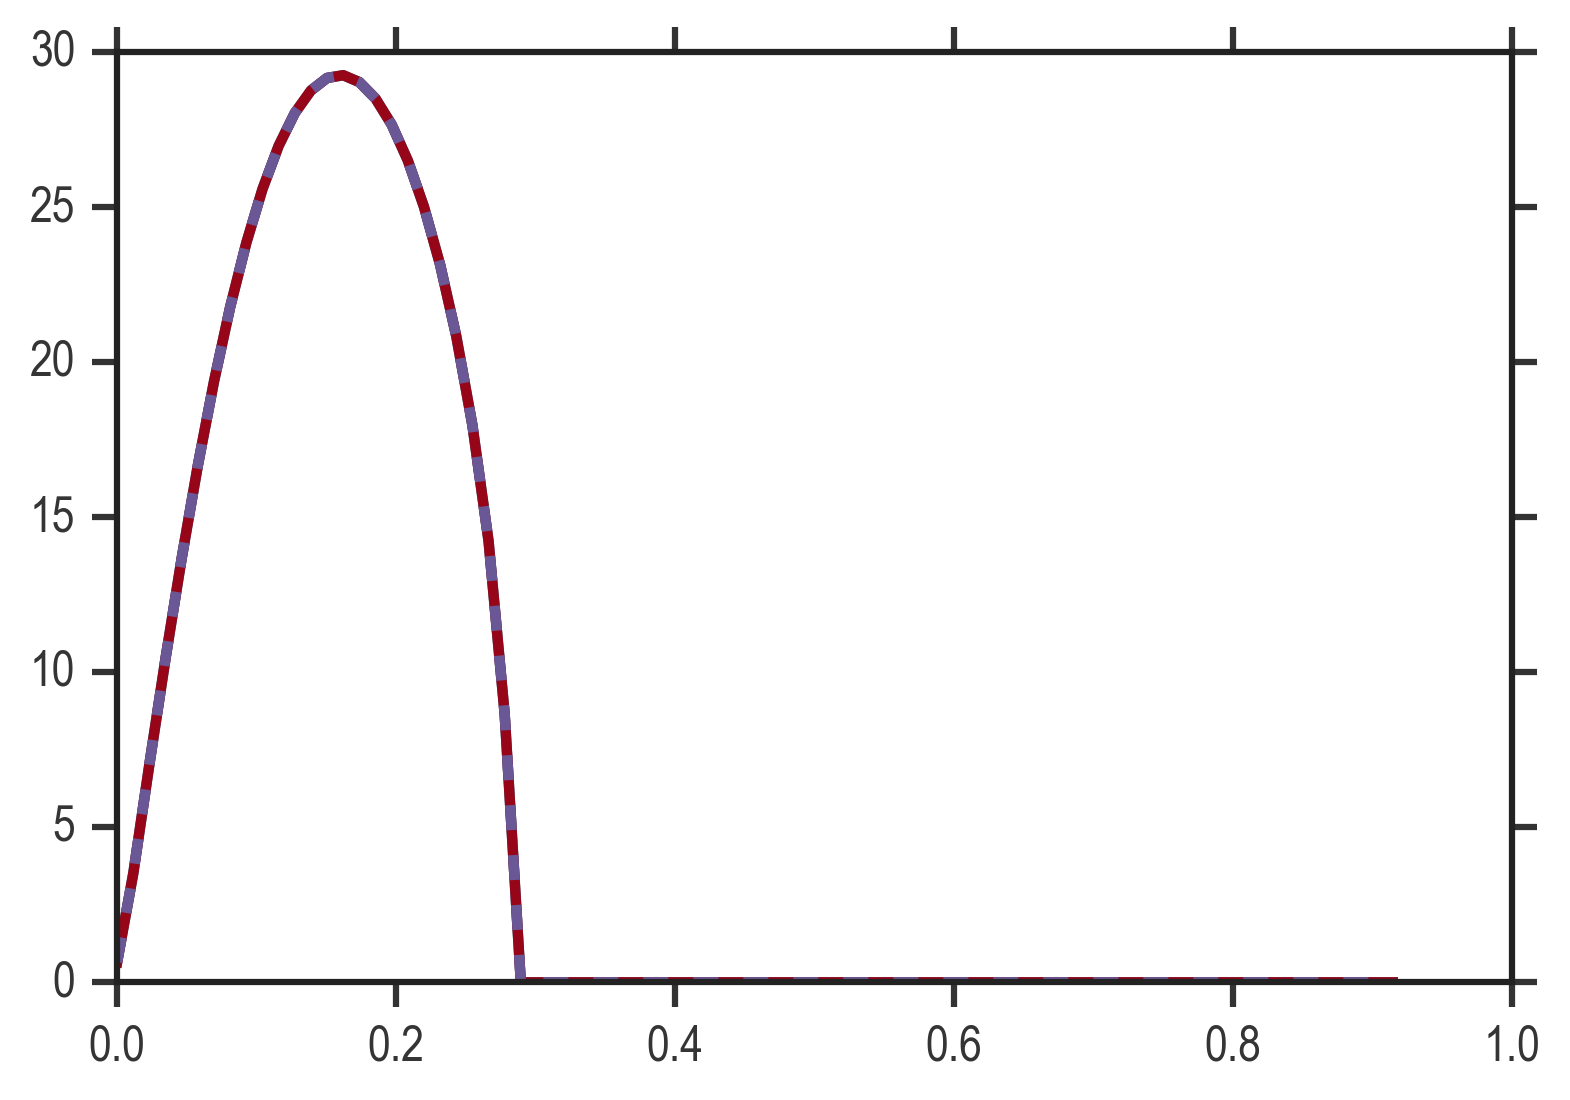

In [396]:
plt.plot(freqs_padded, np.real(10*output_noise * np.sqrt(f)))
plt.plot(freqs_padded, ideal_filter_high_output_noise)
plt.plot(freqs_padded, blah, '--')

The relative error from this choice of Lagrangian multiplier is 4.85671100216e-13.
The relative error from this choice of Lagrangian multiplier is 8.11878289069e-07.
The relative error from this choice of Lagrangian multiplier is 5.44463448576e-07.
The relative error from this choice of Lagrangian multiplier is 8.96734029977e-07.
The relative error from this choice of Lagrangian multiplier is 4.72440929874e-07.
The relative error from this choice of Lagrangian multiplier is 1.46731953188e-06.
The relative error from this choice of Lagrangian multiplier is 9.07904841484e-07.
The relative error from this choice of Lagrangian multiplier is 1.2972808865e-06.
The relative error from this choice of Lagrangian multiplier is 9.62267139556e-07.
The relative error from this choice of Lagrangian multiplier is 4.84392832555e-07.


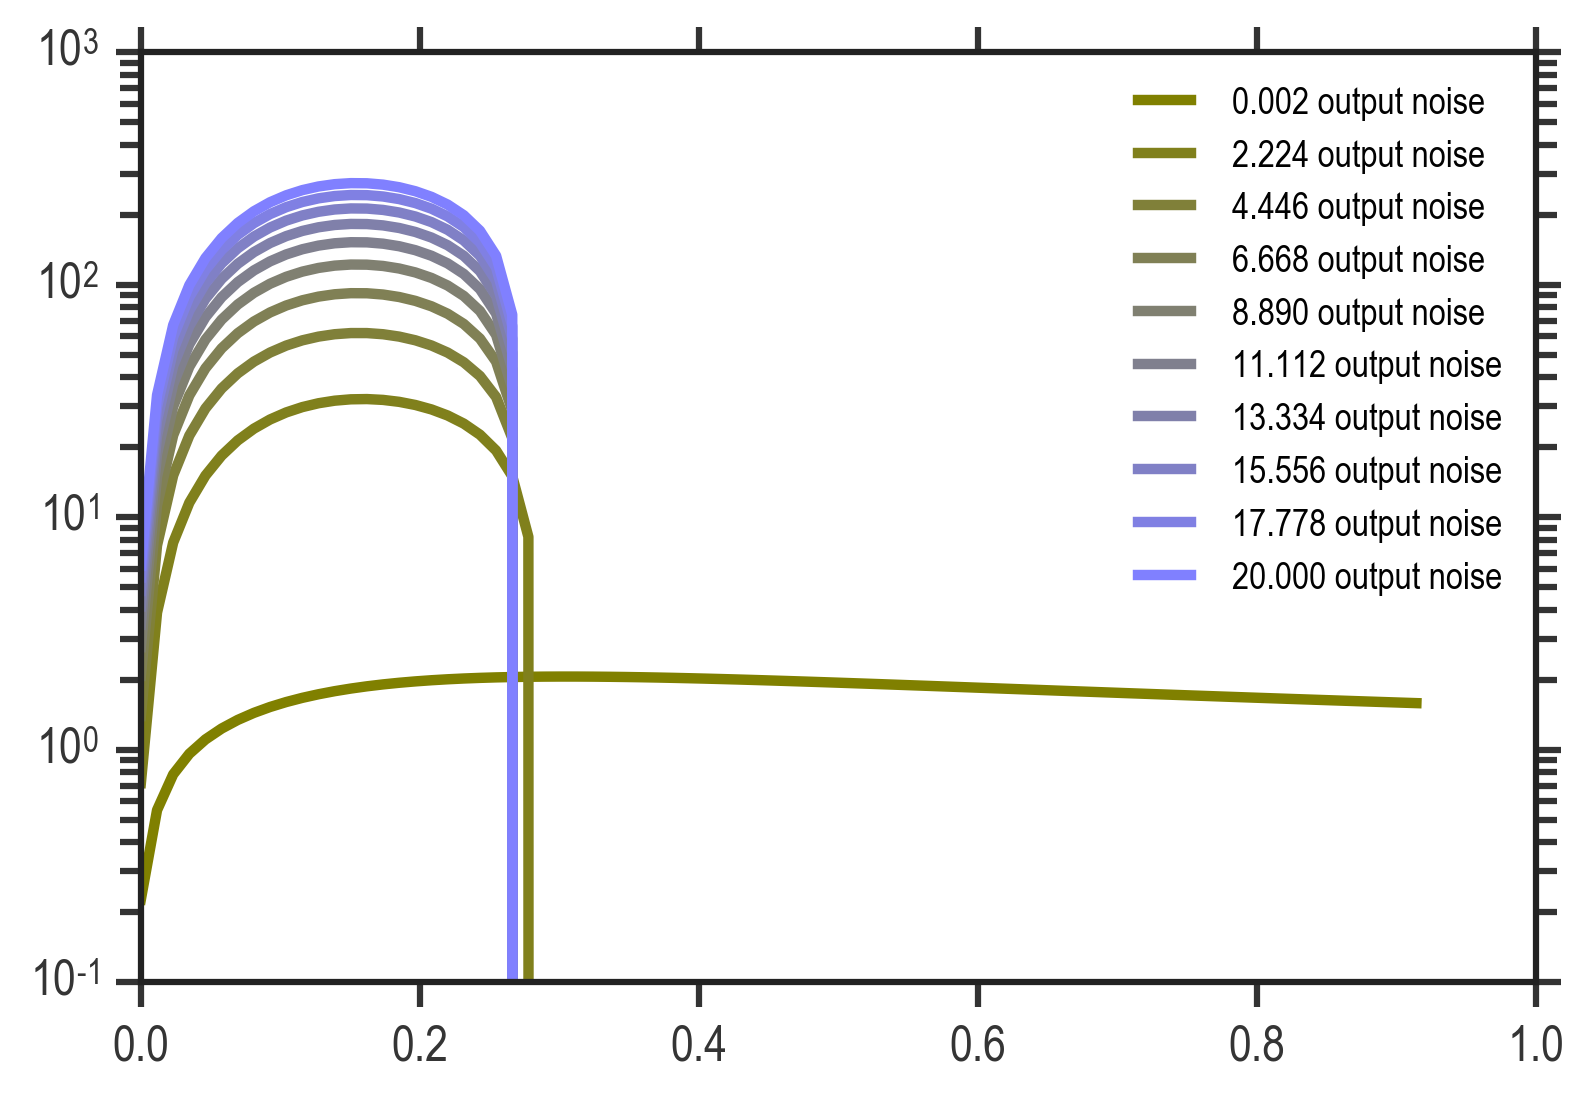

In [413]:
for scale in np.linspace(0.01, 100, 10):
    ideal_filter_variable_output_noise = unique_soln(signal_padded**2, input_noise, scale*output_noise)
    plt.plot(freqs_padded, ideal_filter_variable_output_noise, label='%0.3f output noise' %(scale*output_noise),
            color=[0.5, 0.5, scale/100])
plt.legend(frameon=False, fontsize=9)
plt.yscale('log')

### So there's a phase transition (when output noise < signal power) at higher frequencies, where there will either be zero filter, or a lot of filter power